# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [2]:
# show all observation-related columns/rows
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ";")

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ";")

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.shape

(891221, 85)

In [5]:
feat_info.shape

(85, 4)

In [6]:
azdias.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4            0   
1                      4                 5          1         1996   
2                      3                 5          1         1979   
3                      1                 2          6         1957   
4                      3                 2          5         1963   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0             10.0                 0          -1                 15.0   
1             10.0                 0           3                 21.0   
2             10.0                 1           3                  3.0   
3              1.0                 0           2                  0.0   
4              5.0                 0           3                 32.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  4.0              2.0              2.0             1.0   
1                  6.0              5.0              3.0             2.0   
2                  1.0              1.0              1.0             3.0   
3                  0.0              0.0              0.0             9.0   
4                 10.0             10.0              5.0             3.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             1.0                 0                      0             5.0   
1             1.0                 1                     14             1.0   
2             2.0                 1                     15             3.0   
3             4.0                 1                      8             2.0   
4             2.0                 1                      8             5.0   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0          2          6          7          5           1           5   
1          5          4          4          3           1           2   
2          4          1          3          3           4           4   
3          5          1          2          1           4           4   
4          6          4          4          2           7           4   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0          3           3          4           7          6           6   
1          2           3          6           4          7           4   
2          6           3          4           7          7           7   
3          7           4          3           4          4           5   
4          4           6          2           3          2           2   

   SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  TITEL_KZ  VERS_TYP  \
0              5            3           -1      NaN       NaN        -1   
1              7            6            3      1.0       0.0         2   
2              3            3            2      0.0       0.0         1   
3              4            4            1      0.0       0.0         1   
4              4            2            2      0.0       0.0         2   

   ZABEOTYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCO

In [7]:
azdias.describe().T

count         mean         std     min     25%  \
AGER_TYP               891221.0    -0.358435    1.198724    -1.0    -1.0   
ALTERSKATEGORIE_GROB   891221.0     2.777398    1.068775     1.0     2.0   
ANREDE_KZ              891221.0     1.522098    0.499512     1.0     1.0   
CJT_GESAMTTYP          886367.0     3.632838    1.595021     1.0     2.0   
FINANZ_MINIMALIST      891221.0     3.074528    1.321055     1.0     2.0   
FINANZ_SPARER          891221.0     2.821039    1.464749     1.0     1.0   
FINANZ_VORSORGER       891221.0     3.401106    1.322134     1.0     3.0   
FINANZ_ANLEGER         891221.0     3.033328    1.529603     1.0     2.0   
FINANZ_UNAUFFAELLIGER  891221.0     2.874167    1.486731     1.0     2.0   
FINANZ_HAUSBAUER       891221.0     3.075121    1.353248     1.0     2.0   
FINANZTYP              891221.0     3.790586    1.987876     1.0     2.0   
GEBURTSJAHR            891221.0  1101.178533  976.583551     0.0     0.0   
GFK_URLAUBERTYP        886367.0     7.350304    3.525723     1.0     5.0   
GREEN_AVANTGARDE       891221.0     0.196612    0.397437     0.0     0.0   
HEALTH_TYP             891221.0     1.792102    1.269062    -1.0     1.0   
LP_LEBENSPHASE_FEIN    886367.0    14.622637   12.616883     0.0     4.0   
LP_LEBENSPHASE_GROB    886367.0     4.453621    3.855639     0.0     1.0   
LP_FAMILIE_FEIN        886367.0     3.599574    3.926486     0.0     1.0   
LP_FAMILIE_GROB        886367.0     2.185966    1.756537     0.0     1.0   
LP_STATUS_FEIN         886367.0     4.791151    3.425305     1.0     2.0   
LP_STATUS_GROB         886367.0     2.432575    1.474315     1.0     1.0   
NATIONALITAET_KZ       891221.0     1.026827    0.586634     0.0     1.0   
PRAEGENDE_JUGENDJAHRE  891221.0     8.154346    4.844532     0.0     5.0   
RETOURTYP_BK_S         886367.0     3.419630    1.417741     1.0     2.0   
SEMIO_SOZ              891221.0     3.945860    1.946564     1.0     2.0   
SEMIO_FAM              891221.0     4.272729    1.915885     1.0     3.0   
SEMIO_REL              891221.0     4.240609    2.007373     1.0     3.0   
SEMIO_MAT              891221.0     4.001597    1.857540     1.0     2.0   
SEMIO_VERT             891221.0     4.023709    2.077746     1.0     2.0   
SEMIO_LUST             891221.0     4.359086    2.022829     1.0     2.0   
SEMIO_ERL              891221.0     4.481405    1.807552     1.0     3.0   
SEMIO_KULT             891221.0     4.025014    1.903816     1.0     3.0   
SEMIO_RAT              891221.0     3.910139    1.580306     1.0     3.0   
SEMIO_KRIT             891221.0     4.763223    1.830789     1.0     3.0   
SEMIO_DOM              891221.0     4.667550    1.795712     1.0     3.0   
SEMIO_KAEM             891221.0     4.445007    1.852412     1.0     3.0   
SEMIO_PFLICHT          891221.0     4.256076    1.770137     1.0     3.0   
SEMIO_TRADV            891221.0     3.661784    1.707637     1.0     2.0   
SHOPPER_TYP            891221.0     1.266967    1.287435    -1.0     0.0   
SOHO_KZ                817722.0     0.008423    0.091392     0.0     0.0   
TITEL_KZ               817722.0     0.003483    0.084957     0.0     0.0   
VERS_TYP               891221.0     1.197852    0.952532    -1.0     1.0   
ZABEOTYP               891221.0     3.362438    1.352704     1.0     3.0   
ALTER_HH               817722.0    10.864126    7.639683     0.0     0.0   
ANZ_PERSONEN           817722.0     1.727637    1.155849     0.0     1.0   
ANZ_TITEL              817722.0     0.004162    0.068855     0.0     0.0   
HH_EINKOMMEN_SCORE     872873.0     4.207243    1.624057     1.0     3.0   
KK_KUNDENTYP           306609.0     3.410640    1.628844     1.0     2.0   
W_KEIT_KIND_HH         783619.0     3.933406    1.964701     0.0     2.0   
WOHNDAUER_2008         817722.0     7.908791    1.923137     1.0     8.0   
ANZ_HAUSHALTE_AKTIV    798073.0     8.287263   15.628087     0.0     1.0   
ANZ_HH_TITEL           794213.0     0.040647    0.324028     0.0     0.0  

In [8]:
feat_info

attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]
20         LP_STATUS_GROB            person  categorical                [0]
21       NATIONALITAET_KZ            person  categorical             [-1,0]
22  PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]
23         RETOURTYP_BK_S            person      ordinal                [0]
24              SEMIO_SOZ            person      ordinal             [-1,9]
25              SEMIO_FAM            person      ordinal             [-1,9]
26              SEMIO_REL            person      ordinal             [-1,9]
27              SEMIO_MAT            person      ordinal             [-1,9]
28             SEMIO_VERT            person      ordinal             [-1,9]
29             SEMIO_LUST            person      ordinal             [-1,9]
30              SEMIO_ERL            person      ordinal             [-1,9]
31             SEMIO_KULT            person      ordinal             [-1,9]
32              SEMIO_RAT            person      ordinal             [-1,9]
33             SEMIO_KRIT            person      ordinal             [-1,9]
34              SEMIO_DOM            person      ordinal             [-1,9]
35             SEMIO_KAEM            person      ordinal             [-1,9]
36          SEMIO_PFLICHT            person      ordinal             [-1,9]
37            SEMIO_TRADV            person      ordinal             [-1,9]
38            SHOPPER_TYP            person  categorical               [-1]
39                SOHO_KZ            person  categorical               [-1]
40               TITEL_KZ            person  categorical             [-1,0]
41               VERS_TYP            person  categorical               [-1]
42               ZABEOTYP            person  categorical             [-1,9]
43               ALTER_HH         household     interval                [0]
44           ANZ_PERSONEN         household      numeric                 []
45              ANZ_TITEL         household      numeric                 []
46     HH_EINKOMMEN_SCORE         household      ordinal             [-1,0]
47           KK_KUNDENTYP         household  categorical               [-1]
48         W_KEIT_KIND_HH         household      ordinal             [-1,0]
49         WOHNDAUER_2008         household      ordinal             [-1,0]
50    ANZ_HAUSHALTE_AKTIV          building      numeric                [0]
51           ANZ_HH_TITEL          building      numeric        

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
azdias.head()


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4            0   
1                      4                 5          1         1996   
2                      3                 5          1         1979   
3                      1                 2          6         1957   
4                      3                 2          5         1963   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0             10.0                 0          -1                 15.0   
1             10.0                 0           3                 21.0   
2             10.0                 1           3                  3.0   
3              1.0                 0           2                  0.0   
4              5.0                 0           3                 32.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  4.0              2.0              2.0             1.0   
1                  6.0              5.0              3.0             2.0   
2                  1.0              1.0              1.0             3.0   
3                  0.0              0.0              0.0             9.0   
4                 10.0             10.0              5.0             3.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             1.0                 0                      0             5.0   
1             1.0                 1                     14             1.0   
2             2.0                 1                     15             3.0   
3             4.0                 1                      8             2.0   
4             2.0                 1                      8             5.0   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0          2          6          7          5           1           5   
1          5          4          4          3           1           2   
2          4          1          3          3           4           4   
3          5          1          2          1           4           4   
4          6          4          4          2           7           4   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0          3           3          4           7          6           6   
1          2           3          6           4          7           4   
2          6           3          4           7          7           7   
3          7           4          3           4          4           5   
4          4           6          2           3          2           2   

   SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  TITEL_KZ  VERS_TYP  \
0              5            3           -1      NaN       NaN        -1   
1              7            6            3      1.0       0.0         2   
2              3            3            2      0.0       0.0         1   
3              4            4            1      0.0       0.0         1   
4              4            2            2      0.0       0.0         2   

   ZABEOTYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCO

In [10]:
feat_info.head()

attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

In [11]:
azdias.iloc[:,:1].isnull().sum()

AGER_TYP    0
dtype: int64

In [12]:
# number of records with naturally missing value
print("Number of records with naturally missing values: {}". format(azdias.isnull().any(axis = 1).sum()))

Number of records with naturally missing values: 628074


In [13]:
# number of naturally missing values
print("Number of naturally missing values : {}".format(azdias.isnull().sum().sum()))

Number of naturally missing values : 4896838


In [14]:
azdias2 = azdias.copy()

In [15]:
# map missing value info from feat_info the azdias

for indx in range(len(feat_info)):
    m_o_u = feat_info.iloc[indx]['missing_or_unknown']
    m_o_u = m_o_u.strip("[]")
    m_o_u = m_o_u.split(sep = ",")
      
    m_o_u = [float(value) if (value.lstrip("-").isdigit() and value!= '') else value for value in m_o_u]
    
    #create a mapping dictionary for each attribute

    m_o_u = {m_o_u[i]: np.nan for i in range(len(m_o_u))}
    
    # map each df column using list comprehension
    azdias2[feat_info.iloc[indx]['attribute']] = [np.nan if x in m_o_u else x for x in azdias2[feat_info.iloc[indx]['attribute']]]


In [16]:
azdias2.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4          NaN   
1                      4                 5          1       1996.0   
2                      3                 5          1       1979.0   
3                      1                 2          6       1957.0   
4                      3                 2          5       1963.0   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0             10.0                 0         NaN                 15.0   
1             10.0                 0         3.0                 21.0   
2             10.0                 1         3.0                  3.0   
3              1.0                 0         2.0                  NaN   
4              5.0                 0         3.0                 32.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  4.0              2.0              2.0             1.0   
1                  6.0              5.0              3.0             2.0   
2                  1.0              1.0              1.0             3.0   
3                  NaN              NaN              NaN             9.0   
4                 10.0             10.0              5.0             3.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             1.0               NaN                    NaN             5.0   
1             1.0               1.0                   14.0             1.0   
2             2.0               1.0                   15.0             3.0   
3             4.0               1.0                    8.0             2.0   
4             2.0               1.0                    8.0             5.0   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0          2          6          7          5           1           5   
1          5          4          4          3           1           2   
2          4          1          3          3           4           4   
3          5          1          2          1           4           4   
4          6          4          4          2           7           4   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0          3           3          4           7          6           6   
1          2           3          6           4          7           4   
2          6           3          4           7          7           7   
3          7           4          3           4          4           5   
4          4           6          2           3          2           2   

   SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  TITEL_KZ  VERS_TYP  \
0              5            3          NaN      NaN       NaN       NaN   
1              7            6          3.0      1.0       NaN       2.0   
2              3            3          2.0      0.0       NaN       1.0   
3              4            4          1.0      0.0       NaN       1.0   
4              4            2          2.0      0.0       NaN       2.0   

   ZABEOTYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCO

In [17]:
print(f'Total number of missing values after conversion is {azdias2.isnull().sum().sum()}')

Total number of missing values after conversion is 8373929


In [18]:
azdias2.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4          NaN   
1                      4                 5          1       1996.0   
2                      3                 5          1       1979.0   
3                      1                 2          6       1957.0   
4                      3                 2          5       1963.0   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0             10.0                 0         NaN                 15.0   
1             10.0                 0         3.0                 21.0   
2             10.0                 1         3.0                  3.0   
3              1.0                 0         2.0                  NaN   
4              5.0                 0         3.0                 32.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  4.0              2.0              2.0             1.0   
1                  6.0              5.0              3.0             2.0   
2                  1.0              1.0              1.0             3.0   
3                  NaN              NaN              NaN             9.0   
4                 10.0             10.0              5.0             3.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             1.0               NaN                    NaN             5.0   
1             1.0               1.0                   14.0             1.0   
2             2.0               1.0                   15.0             3.0   
3             4.0               1.0                    8.0             2.0   
4             2.0               1.0                    8.0             5.0   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0          2          6          7          5           1           5   
1          5          4          4          3           1           2   
2          4          1          3          3           4           4   
3          5          1          2          1           4           4   
4          6          4          4          2           7           4   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0          3           3          4           7          6           6   
1          2           3          6           4          7           4   
2          6           3          4           7          7           7   
3          7           4          3           4          4           5   
4          4           6          2           3          2           2   

   SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  TITEL_KZ  VERS_TYP  \
0              5            3          NaN      NaN       NaN       NaN   
1              7            6          3.0      1.0       NaN       2.0   
2              3            3          2.0      0.0       NaN       1.0   
3              4            4          1.0      0.0       NaN       1.0   
4              4            2          2.0      0.0       NaN       2.0   

   ZABEOTYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCO

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [19]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_per_column = pd.DataFrame((azdias2.isnull().sum()/len(azdias2)) * 100)
missing_per_column.reset_index(inplace = True)

In [20]:
missing_per_column.columns = ['attribute', 'percentage_of_missing']
missing_per_column.sort_values(by = 'percentage_of_missing', ascending= False).head(10)

attribute  percentage_of_missing
40        TITEL_KZ              99.757636
0         AGER_TYP              76.955435
47    KK_KUNDENTYP              65.596749
64    KBA05_BAUMAX              53.468668
11     GEBURTSJAHR              44.020282
43        ALTER_HH              34.813699
70             KKK              17.735668
73        REGIOTYP              17.735668
48  W_KEIT_KIND_HH              16.605084
60     KBA05_ANTG1              14.959701

In [21]:
missing_per_column[missing_per_column['percentage_of_missing'] < 1].sort_values(by = "percentage_of_missing")

attribute  percentage_of_missing
24              SEMIO_SOZ               0.000000
30              SEMIO_ERL               0.000000
29             SEMIO_LUST               0.000000
28             SEMIO_VERT               0.000000
27              SEMIO_MAT               0.000000
26              SEMIO_REL               0.000000
25              SEMIO_FAM               0.000000
42               ZABEOTYP               0.000000
33             SEMIO_KRIT               0.000000
34              SEMIO_DOM               0.000000
35             SEMIO_KAEM               0.000000
13       GREEN_AVANTGARDE               0.000000
36          SEMIO_PFLICHT               0.000000
10              FINANZTYP               0.000000
9        FINANZ_HAUSBAUER               0.000000
8   FINANZ_UNAUFFAELLIGER               0.000000
7          FINANZ_ANLEGER               0.000000
6        FINANZ_VORSORGER               0.000000
5           FINANZ_SPARER               0.000000
4       FINANZ_MINIMALIST               0.000000
37            SEMIO_TRADV               0.000000
2               ANREDE_KZ               0.000000
31             SEMIO_KULT               0.000000
32              SEMIO_RAT               0.000000
1    ALTERSKATEGORIE_GROB               0.323264
20         LP_STATUS_GROB               0.544646
19         LP_STATUS_FEIN               0.544646
12        GFK_URLAUBERTYP               0.544646
3           CJT_GESAMTTYP               0.544646
23         RETOURTYP_BK_S               0.544646
72      ONLINE_AFFINITAET               0.544646

Columns starting with SEMIO, FINANZ and a few others do not have any missing value. These could be compulsory data for each record.

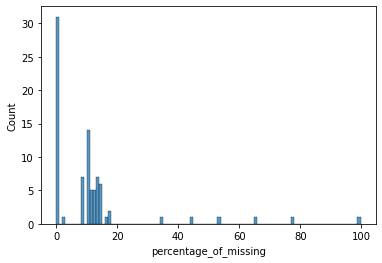

In [22]:
# Investigate patterns in the amount of missing data in each column.

fig = sns.histplot(data = missing_per_column, x = "percentage_of_missing", bins = 100)

plt.show(fig)

In [23]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# define outliers as those with percentage of missing data above 30%.
outliers = missing_per_column['attribute'][missing_per_column['percentage_of_missing'] > 30]
outliers

0         AGER_TYP
11     GEBURTSJAHR
40        TITEL_KZ
43        ALTER_HH
47    KK_KUNDENTYP
64    KBA05_BAUMAX
Name: attribute, dtype: object

Attempting to see any pattern of the missing value from original dataframe

In [24]:
azdias[outliers].describe()

AGER_TYP    GEBURTSJAHR       TITEL_KZ       ALTER_HH  \
count  891221.000000  891221.000000  817722.000000  817722.000000   
mean       -0.358435    1101.178533       0.003483      10.864126   
std         1.198724     976.583551       0.084957       7.639683   
min        -1.000000       0.000000       0.000000       0.000000   
25%        -1.000000       0.000000       0.000000       0.000000   
50%        -1.000000    1943.000000       0.000000      13.000000   
75%        -1.000000    1970.000000       0.000000      17.000000   
max         3.000000    2017.000000       5.000000      21.000000   

        KK_KUNDENTYP   KBA05_BAUMAX  
count  306609.000000  757897.000000  
mean        3.410640       1.389552  
std         1.628844       1.779483  
min         1.000000       0.000000  
25%         2.000000       0.000000  
50%         3.000000       1.000000  
75%         5.000000       3.000000  
max         6.000000       5.000000

In [25]:
azdias[outliers].iloc[:,0].value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [26]:
azdias[outliers].iloc[:,1].value_counts()

0       392318
1967     11183
1965     11090
1966     10933
1970     10883
1964     10799
1968     10792
1963     10513
1969     10360
1980     10275
1962     10082
1961      9880
1971      9786
1982      9516
1978      9509
1960      9492
1979      9422
1981      9374
1977      9296
1959      9098
1972      9027
1976      9005
1983      8887
1974      8676
1984      8553
1975      8480
1973      8356
1958      8323
1986      8192
1985      8180
1957      8099
1956      8039
1955      7828
1988      7801
1987      7767
1954      7533
1989      7251
1952      7106
1953      7096
1950      7071
1990      6848
1951      6832
1949      6657
1941      6235
1948      5833
1991      5741
1944      5493
1947      5475
1943      5442
1942      5222
1992      5200
1946      4808
1993      4635
1940      4561
1994      4249
1939      4226
1945      4113
1996      4047
1997      4026
1995      4009
1938      3862
1937      3369
1936      3074
1935      2951
1934      2526
1933      1862
1932      

In [27]:
feat_info[feat_info['attribute'] == 'GEBURTSJAHR']

attribute information_level     type missing_or_unknown
11  GEBURTSJAHR            person  numeric                [0]

In [28]:
azdias[outliers].iloc[:,2].value_counts()

0.0    815562
1.0      1947
5.0       104
4.0        57
3.0        49
2.0         3
Name: TITEL_KZ, dtype: int64

In [29]:
feat_info[feat_info['attribute'] == 'TITEL_KZ']

attribute information_level         type missing_or_unknown
40  TITEL_KZ            person  categorical             [-1,0]

In [30]:
azdias[outliers].iloc[:,3].value_counts()

0.0     236768
18.0     60852
17.0     55665
19.0     52890
15.0     51867
16.0     51857
14.0     44275
21.0     41610
20.0     40671
13.0     37612
12.0     34923
10.0     30419
11.0     27924
9.0      22817
8.0      13463
7.0       8419
6.0       3809
5.0       1030
4.0        603
3.0        200
2.0         47
1.0          1
Name: ALTER_HH, dtype: int64

In [31]:
feat_info[feat_info['attribute'] == 'ALTER_HH']

attribute information_level      type missing_or_unknown
43  ALTER_HH         household  interval                [0]

In [32]:
azdias[outliers].iloc[:,4].value_counts()

3.0    65151
2.0    62564
5.0    48038
4.0    44512
6.0    44114
1.0    42230
Name: KK_KUNDENTYP, dtype: int64

In [33]:
feat_info[feat_info['attribute'] == 'KK_KUNDENTYP']

attribute information_level         type missing_or_unknown
47  KK_KUNDENTYP         household  categorical               [-1]

In [34]:
# Remove outlier columns
azdias2 = azdias2.drop(outliers, axis = 1) 
azdias2.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                   2.0          1            2.0                  3   
1                   1.0          2            5.0                  1   
2                   3.0          2            3.0                  1   
3                   4.0          2            2.0                  4   
4                   3.0          1            5.0                  4   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0              4                 3               5                      5   
1              5                 2               5                      4   
2              4                 1               2                      3   
3              2                 5               2                      1   
4              3                 4               1                      3   

   FINANZ_HAUSBAUER  FINANZTYP  GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  \
0                 3          4             10.0                 0         NaN   
1                 5          1             10.0                 0         3.0   
2                 5          1             10.0                 1         3.0   
3                 2          6              1.0                 0         2.0   
4                 2          5              5.0                 0         3.0   

   LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  \
0                 15.0                  4.0              2.0              2.0   
1                 21.0                  6.0              5.0              3.0   
2                  3.0                  1.0              1.0              1.0   
3                  NaN                  NaN              NaN              NaN   
4                 32.0                 10.0             10.0              5.0   

   LP_STATUS_FEIN  LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  \
0             1.0             1.0               NaN                    NaN   
1             2.0             1.0               1.0                   14.0   
2             3.0             2.0               1.0                   15.0   
3             9.0             4.0               1.0                    8.0   
4             3.0             2.0               1.0                    8.0   

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
0             5.0          2          6          7          5           1   
1             1.0          5          4          4          3           1   
2             3.0          4          1          3          3           4   
3             2.0          5          1          2          1           4   
4             5.0          6          4          4          2           7   

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
0           5          3           3          4           7          6   
1           2          2           3          6           4          7   
2           4          6           3          4           7          7   
3           4          7           4          3           4          4   
4           4          4           6          2           3          2   

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  VERS_TYP  \
0           6              5            3          NaN      NaN       NaN   
1           4              7            6          3.0      1.0       2.0   
2           7              3            3          2.0      0.0       1.0   
3           5              4            4          1.0      0.0       1.0   
4           2              4            2          2.0      0.0       2.0   

   ZABEOTYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  \
0         3           NaN        NaN                 2.0             NaN   
1         5           2.0        0.0                 6.0             3.0   
2         5           1.0        0.0                 4.0         

In [35]:
azdias2.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

Entire dataset contained 4,896,838 missing values identified using Pandas isnull. After manually encoding NA tags, there are 8,373,929 missing values.

Most of the columns have less than 30% missing values. There are 6 columns with missing value of more than 30%. 5 of columns are identified as outliers after mapping the missing_or_unknown code from feat_info. 1 of the columns, KK_KUNDENTYP has 65% missing values before mapping the missing_or_unknown code.

These columns are deemed to be outliers and removed:
1.         AGER_TYP  
2.     GEBURTSJAHR  
3.        TITEL_KZ  
4.        ALTER_HH  
5.    KK_KUNDENTYP --> this is naturally missing in original data
6.    KBA05_BAUMAX  

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [36]:
# How much data is missing in each row of the dataset?

missing_val_per_row = azdias2.isnull().sum(axis = 1)
missing_val_per_row

0         43
1          0
2          0
3          7
4          0
          ..
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [37]:
missing_val_per_row.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

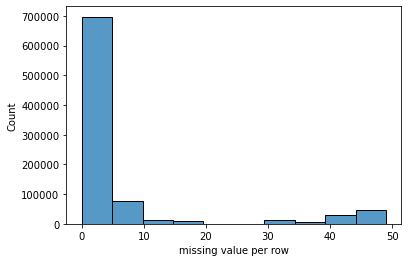

In [38]:
sns.histplot(data = missing_val_per_row, bins = 10)
plt.xlabel("missing value per row")
plt.show()

It appears that there are 2 groups of the data, those with more than 25 missing values and those with less than 25 missing values each row

In [39]:
azdias2['na_row_count'] = azdias2.isnull().sum(axis = 1)

In [40]:
azdias2['na_row_count'].describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
Name: na_row_count, dtype: float64

In [41]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_less_25 = azdias2[azdias2['na_row_count'] <= 25]
azdias_more_25 = azdias2[azdias2['na_row_count'] > 25]

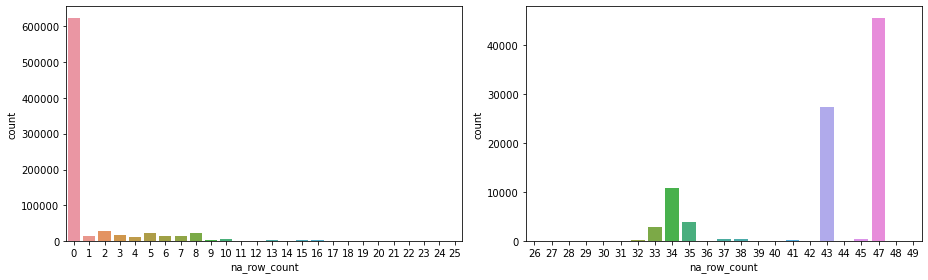

In [42]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(13,4))
sns.countplot(x='na_row_count',data=azdias_less_25,ax=ax1,orient='v')
sns.countplot(x='na_row_count',data=azdias_more_25,ax=ax2,orient='v')
plt.tight_layout()

In [43]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

top10_few_missing_col = list(missing_per_column.sort_values(by = 'percentage_of_missing', ascending= True).head(10)['attribute'])
top10_few_missing_col

['ZABEOTYP',
 'SEMIO_TRADV',
 'SEMIO_PFLICHT',
 'SEMIO_KAEM',
 'SEMIO_DOM',
 'SEMIO_KRIT',
 'SEMIO_RAT',
 'SEMIO_KULT',
 'SEMIO_ERL',
 'SEMIO_LUST']

In [44]:
def plot_compare(column):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_figwidth(15)
    ax1.set_title("Row with less than 25 missing values")
    sns.countplot(x = azdias.loc[azdias_less_25.index,column], ax = ax1)
    
    ax2.set_title("Row with more than 25 missing values")
    sns.countplot(x = azdias.loc[azdias_more_25.index,column], ax = ax2)
    
    plt.show()

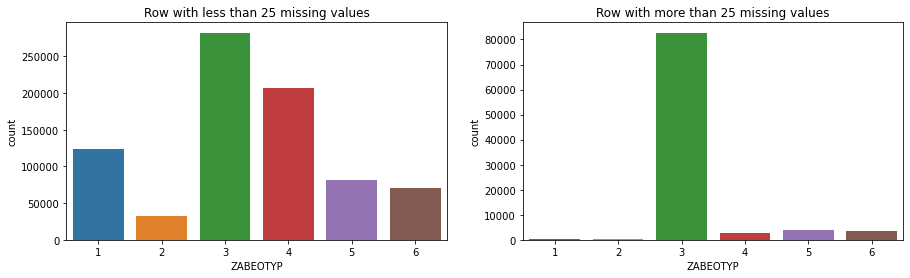

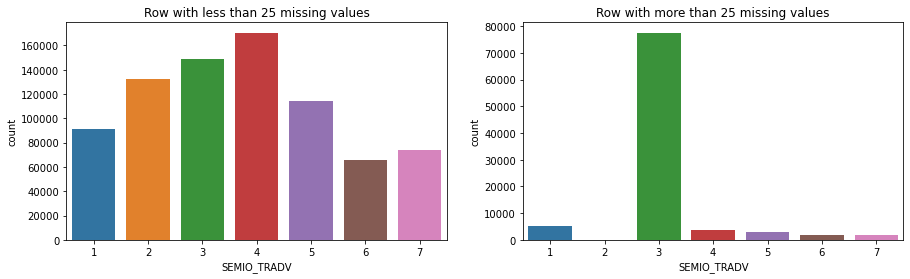

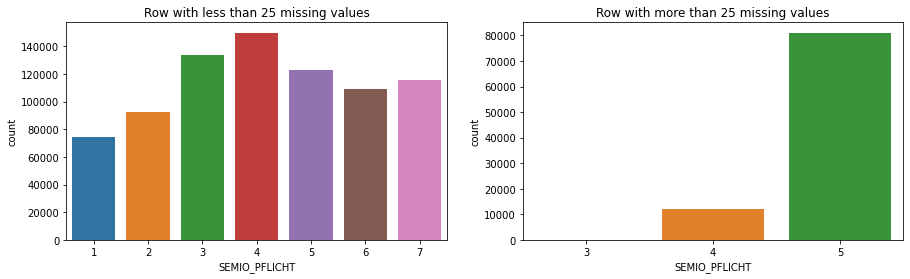

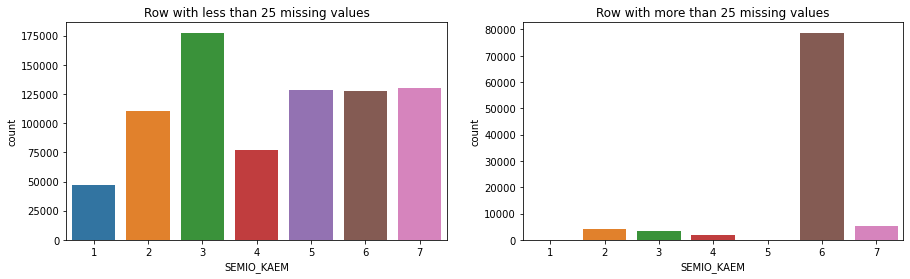

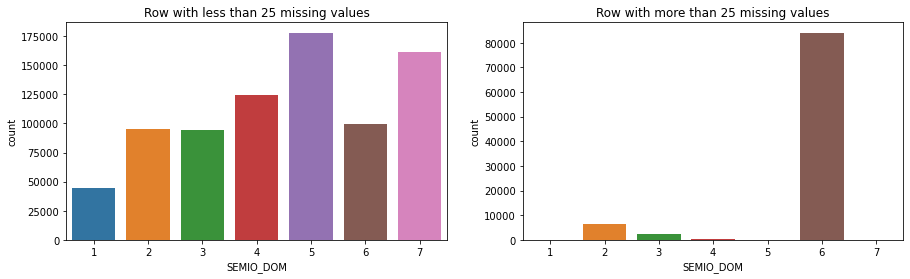

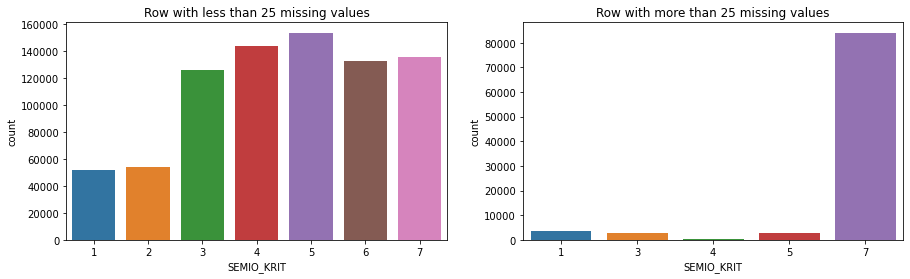

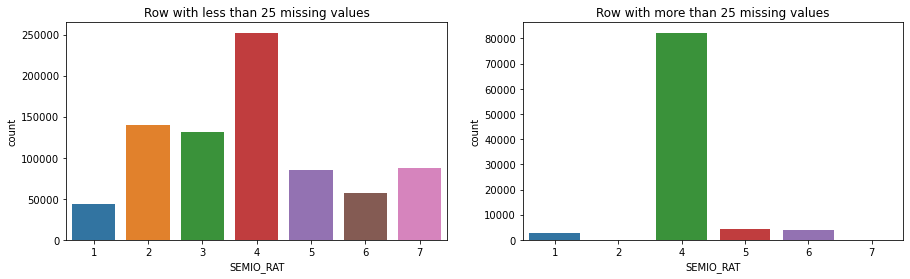

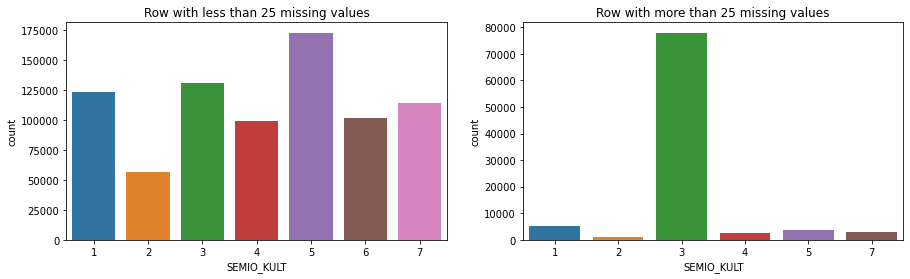

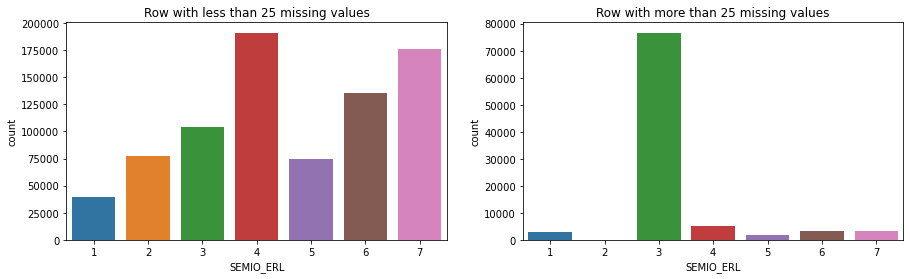

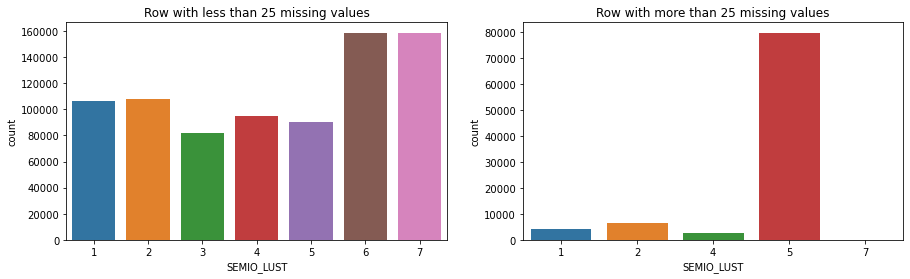

In [45]:
for i in range(len(top10_few_missing_col)):
    plot_compare(top10_few_missing_col[i])

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Subset of data with more than 25 missing values in each row is **smaller** than the subset of data with less missing values.  
The distribution of specific column values between the subsets are also different when they actually should be similar.  

This could be due to the way the data was collected resulting in bias.  
Further investigation is needed to determine the reason for missing values  

In [46]:
prop_25 = len(azdias_more_25)/len(azdias2)
print(f"{prop_25*100:.2f}% of our data has more than 25 missing values in a row")

10.46% of our data has more than 25 missing values in a row


More than 10% of our data has more than 25 missing values in a row.  
For simplicity sake and given significant number of missing features each row (25 out of 79 features), we will drop these rows.

In [47]:
#use the subset with fewer missing values
azdias3 = azdias_less_25.loc[:, azdias_less_25.columns != 'na_row_count'].copy()

In [48]:
azdias3.shape

(797961, 79)

In [49]:
azdias3.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
1                   1.0          2            5.0                  1   
2                   3.0          2            3.0                  1   
3                   4.0          2            2.0                  4   
4                   3.0          1            5.0                  4   
5                   1.0          2            2.0                  3   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
1              5                 2               5                      4   
2              4                 1               2                      3   
3              2                 5               2                      1   
4              3                 4               1                      3   
5              1                 5               2                      2   

   FINANZ_HAUSBAUER  FINANZTYP  GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  \
1                 5          1             10.0                 0         3.0   
2                 5          1             10.0                 1         3.0   
3                 2          6              1.0                 0         2.0   
4                 2          5              5.0                 0         3.0   
5                 5          2              1.0                 0         3.0   

   LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  \
1                 21.0                  6.0              5.0              3.0   
2                  3.0                  1.0              1.0              1.0   
3                  NaN                  NaN              NaN              NaN   
4                 32.0                 10.0             10.0              5.0   
5                  8.0                  2.0              1.0              1.0   

   LP_STATUS_FEIN  LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  \
1             2.0             1.0               1.0                   14.0   
2             3.0             2.0               1.0                   15.0   
3             9.0             4.0               1.0                    8.0   
4             3.0             2.0               1.0                    8.0   
5             4.0             2.0               1.0                    3.0   

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
1             1.0          5          4          4          3           1   
2             3.0          4          1          3          3           4   
3             2.0          5          1          2          1           4   
4             5.0          6          4          4          2           7   
5             3.0          2          4          7          4           2   

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
1           2          2           3          6           4          7   
2           4          6           3          4           7          7   
3           4          7           4          3           4          4   
4           4          4           6          2           3          2   
5           2          2           5          7           4          4   

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  VERS_TYP  \
1           4              7            6          3.0      1.0       2.0   
2           7              3            3          2.0      0.0       1.0   
3           5              4            4          1.0      0.0       1.0   
4           2              4            2          2.0      0.0       2.0   
5           4              7            6          0.0      0.0       2.0   

   ZABEOTYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  \
1         5           2.0        0.0                 6.0             3.0   
2         5           1.0        0.0                 4.0             3.0   
3         3           0.0        0.0                 1.0         

In [50]:
azdias3.shape

(797961, 79)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [51]:
# How many features are there of each data type?
feat_azdias3 = feat_info[feat_info['attribute'].isin(azdias3)]
feat_azdias3

attribute information_level         type missing_or_unknown
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]
20         LP_STATUS_GROB            person  categorical                [0]
21       NATIONALITAET_KZ            person  categorical             [-1,0]
22  PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]
23         RETOURTYP_BK_S            person      ordinal                [0]
24              SEMIO_SOZ            person      ordinal             [-1,9]
25              SEMIO_FAM            person      ordinal             [-1,9]
26              SEMIO_REL            person      ordinal             [-1,9]
27              SEMIO_MAT            person      ordinal             [-1,9]
28             SEMIO_VERT            person      ordinal             [-1,9]
29             SEMIO_LUST            person      ordinal             [-1,9]
30              SEMIO_ERL            person      ordinal             [-1,9]
31             SEMIO_KULT            person      ordinal             [-1,9]
32              SEMIO_RAT            person      ordinal             [-1,9]
33             SEMIO_KRIT            person      ordinal             [-1,9]
34              SEMIO_DOM            person      ordinal             [-1,9]
35             SEMIO_KAEM            person      ordinal             [-1,9]
36          SEMIO_PFLICHT            person      ordinal             [-1,9]
37            SEMIO_TRADV            person      ordinal             [-1,9]
38            SHOPPER_TYP            person  categorical               [-1]
39                SOHO_KZ            person  categorical               [-1]
41               VERS_TYP            person  categorical               [-1]
42               ZABEOTYP            person  categorical             [-1,9]
44           ANZ_PERSONEN         household      numeric                 []
45              ANZ_TITEL         household      numeric                 []
46     HH_EINKOMMEN_SCORE         household      ordinal             [-1,0]
48         W_KEIT_KIND_HH         household      ordinal             [-1,0]
49         WOHNDAUER_2008         household      ordinal             [-1,0]
50    ANZ_HAUSHALTE_AKTIV          building      numeric                [0]
51           ANZ_HH_TITEL          building      numeric                 []
52            GEBAEUDETYP          building  categorical             [-1,0]
53            KONSUMNAEHE          building      ordinal                 []
54       MIN_GEBAEUDEJAHR          building      numeric                [0]
55            OST_WEST_KZ          building  categorical               [-1]
56               WOHNLAGE          building        mixed        

In [52]:
feat_azdias3['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [53]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_var = feat_azdias3[feat_azdias3['type'] =='categorical']

categorical_var

attribute information_level         type missing_or_unknown
2          ANREDE_KZ            person  categorical             [-1,0]
3      CJT_GESAMTTYP            person  categorical                [0]
10         FINANZTYP            person  categorical               [-1]
12   GFK_URLAUBERTYP            person  categorical                 []
13  GREEN_AVANTGARDE            person  categorical                 []
17   LP_FAMILIE_FEIN            person  categorical                [0]
18   LP_FAMILIE_GROB            person  categorical                [0]
19    LP_STATUS_FEIN            person  categorical                [0]
20    LP_STATUS_GROB            person  categorical                [0]
21  NATIONALITAET_KZ            person  categorical             [-1,0]
38       SHOPPER_TYP            person  categorical               [-1]
39           SOHO_KZ            person  categorical               [-1]
41          VERS_TYP            person  categorical               [-1]
42          ZABEOTYP            person  categorical             [-1,9]
52       GEBAEUDETYP          building  categorical             [-1,0]
55       OST_WEST_KZ          building  categorical               [-1]
57   CAMEO_DEUG_2015     microcell_rr4  categorical             [-1,X]
58    CAMEO_DEU_2015     microcell_rr4  categorical               [XX]

In [54]:
binary_category = []
multilevel_category = []

for attr in categorical_var['attribute']:
    if azdias3[attr].nunique()==2:
        binary_category.append(attr)
    else:
        multilevel_category.append(attr)

In [55]:
binary_category

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [56]:
azdias3[binary_category].head()

ANREDE_KZ  GREEN_AVANTGARDE  SOHO_KZ  VERS_TYP OST_WEST_KZ
1          2                 0      1.0       2.0           W
2          2                 1      0.0       1.0           W
3          2                 0      0.0       1.0           W
4          1                 0      0.0       2.0           W
5          2                 0      0.0       2.0           W

OST_WEST_KZ needs to be encoded to numerical

In [57]:
# Re-encode binary categorical variable(s) to be kept in the analysis.

azdias3['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

In [58]:
for attr in binary_category:
    print(azdias3[attr].value_counts())

2    416117
1    381844
Name: ANREDE_KZ, dtype: int64
0    622741
1    175220
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791245
1.0      6716
Name: SOHO_KZ, dtype: int64
2.0    394229
1.0    367052
Name: VERS_TYP, dtype: int64
1    629433
0    168528
Name: OST_WEST_KZ, dtype: int64


In [59]:
# multi level categories
multilevel_category

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [60]:
# Re-encode multilevel categorical variable(s) to be kept in the analysis.

azdias3 = pd.get_dummies(azdias3, columns = multilevel_category)

In [61]:
azdias3.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_7E', 'CAMEO_DEU_2015_8A', 'CAMEO_DEU_2015_8B',
       'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A',
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E'],
      dtype='object', length=194)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

There are 18 categorical features, out of which, 4 are binary categorical features and 14 are multilevel categorical features.  
Out of the 4 binary categorical features, 1 is non-numeric and I manually map "W" to 1, "O" to 0.  

The remainder 14 multilevel categorical features are dealt with using one hot encoding (pd.get_dummies).

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [62]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [63]:

# Generation 
generations = {0: [1, 2], # 40s
               1: [3, 4], # 50s
               2: [5, 6, 7], # 60s
               3: [8, 9], # 70s
               4: [10, 11, 12, 13], # 80s
               5:[14, 15]} # 90s

def classify_generation(input):
    try:
        for key, values in generations.items():
            if input in values:
                return key
            
    # if input is NaN    
    except ValueError:
        return np.nan
    
# Movement
mainstream = [1,3,5,8,10,12,14]

def classify_movement(input):
    try:
        if input in mainstream:
            return 1
        else:
            return 0
        
    # if input is NaN
    except ValueError:
        return np.nan

In [64]:
# Engineer generation

azdias3['PRAEGENDE_JUGENDJAHRE_GEN'] = azdias3['PRAEGENDE_JUGENDJAHRE'].apply(classify_generation)

In [65]:
# Engineer movement

azdias3['PRAEGENDE_JUGENDJAHRE_MOV'] = azdias3['PRAEGENDE_JUGENDJAHRE'].apply(classify_movement)

In [66]:
azdias3.head().T

1       2       3       4       5
ALTERSKATEGORIE_GROB          1.0     3.0     4.0     3.0     1.0
ANREDE_KZ                       2       2       2       1       2
FINANZ_MINIMALIST               1       1       4       4       3
FINANZ_SPARER                   5       4       2       3       1
FINANZ_VORSORGER                2       1       5       4       5
FINANZ_ANLEGER                  5       2       2       1       2
FINANZ_UNAUFFAELLIGER           4       3       1       3       2
FINANZ_HAUSBAUER                5       5       2       2       5
GREEN_AVANTGARDE                0       1       0       0       0
HEALTH_TYP                    3.0     3.0     2.0     3.0     3.0
LP_LEBENSPHASE_FEIN          21.0     3.0     NaN    32.0     8.0
LP_LEBENSPHASE_GROB           6.0     1.0     NaN    10.0     2.0
PRAEGENDE_JUGENDJAHRE        14.0    15.0     8.0     8.0     3.0
RETOURTYP_BK_S                1.0     3.0     2.0     5.0     3.0
SEMIO_SOZ                       5       4       5       6       2
SEMIO_FAM                       4       1       1       4       4
SEMIO_REL                       4       3       2       4       7
SEMIO_MAT                       3       3       1       2       4
SEMIO_VERT                      1       4       4       7       2
SEMIO_LUST                      2       4       4       4       2
SEMIO_ERL                       2       6       7       4       2
SEMIO_KULT                      3       3       4       6       5
SEMIO_RAT                       6       4       3       2       7
SEMIO_KRIT                      4       7       4       3       4
SEMIO_DOM                       7       7       4       2       4
SEMIO_KAEM                      4       7       5       2       4
SEMIO_PFLICHT                   7       3       4       4       7
SEMIO_TRADV                     6       3       4       2       6
SOHO_KZ                       1.0     0.0     0.0     0.0     0.0
VERS_TYP                      2.0     1.0     1.0     2.0     2.0
ANZ_PERSONEN                  2.0     1.0     0.0     4.0     1.0
ANZ_TITEL                     0.0     0.0     0.0     0.0     0.0
HH_EINKOMMEN_SCORE            6.0     4.0     1.0     5.0     5.0
W_KEIT_KIND_HH                3.0     3.0     NaN     2.0     6.0
WOHNDAUER_2008                9.0     9.0     9.0     9.0     9.0
ANZ_HAUSHALTE_AKTIV          11.0    10.0     1.0     3.0     5.0
ANZ_HH_TITEL                  0.0     0.0     0.0     0.0     0.0
KONSUMNAEHE                   1.0     5.0     4.0     4.0     5.0
MIN_GEBAEUDEJAHR           1992.0  1992.0  1997.0  1992.0  1992.0
OST_WEST_KZ                     1       1       1       1       1
WOHNLAGE                      4.0     2.0     7.0     3.0     7.0
CAMEO_INTL_2015                51      24      12      43      54
KBA05_ANTG1                   0.0     1.0     4.0     1.0     2.0
KBA05_ANTG2                   0.0     3.0     1.0     4.0     2.0
KBA05_ANTG3                   0.0     1.0     0.0     1.0     0.0
KBA05_ANTG4                   2.0     0.0     0.0     0.0     0.0
KBA05_GBZ                     1.0     3.0     4.0     3.0     4.0
BALLRAUM                      6.0     2.0     4.0     2.0     6.0
EWDICHTE                      3.0     4.0     2.0     5.0     2.0
INNENSTADT                    8.0     4.0     6.0     1.0     7.0
GEBAEUDETYP_RASTER            3.0     4.0     4.0     5.0     4.0
KKK                           2.0     2.0     NaN     3.0     4.0
MOBI_REGIO                    1.0     3.0     4.0     3.0     4.0
ONLINE_AFFINITAET             3.0     2.0     1.0     5.0     1.0
REGIOTYP                      3.0     2.0     NaN     5.0     5.0
KBA13_ANZAHL_PKW            963.0   712.0   596.0   435.0  1300.0
PLZ8_ANTG1                    2.0     3.0     2.0     2.0     2.0
PLZ8_ANTG2                    3.0     3.0     2.0     4.0     3.0
PLZ8_ANTG3                    2.0     1.0     2.0     2.0     1.0
PLZ8_ANTG4                    1.0     0.0     0.0     1.0     1.0
PLZ8_B

In [67]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.


### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [68]:
# wealth is derived from 1st digit, while the family status is from the second digit

# Wealth

def classify_wealth(input):
    try:
        return int(str(input)[0])
    
    # If input is NaN
    except:
        return np.nan
    

# Family type

def classify_family(input):
    try:
        return int(str(input)[1])
    
    # If input is NaN
    except:
        return np.nan


In [69]:
# Engineer wealth
azdias3['CAMEO_INTL_2015_WEALTH'] = azdias3['CAMEO_INTL_2015'].apply(classify_wealth)

In [70]:
# Engineer family
azdias3['CAMEO_INTL_2015_FAM'] = azdias3['CAMEO_INTL_2015'].apply(classify_family)

In [71]:
azdias3.head().T

1       2       3       4       5
ALTERSKATEGORIE_GROB          1.0     3.0     4.0     3.0     1.0
ANREDE_KZ                       2       2       2       1       2
FINANZ_MINIMALIST               1       1       4       4       3
FINANZ_SPARER                   5       4       2       3       1
FINANZ_VORSORGER                2       1       5       4       5
FINANZ_ANLEGER                  5       2       2       1       2
FINANZ_UNAUFFAELLIGER           4       3       1       3       2
FINANZ_HAUSBAUER                5       5       2       2       5
GREEN_AVANTGARDE                0       1       0       0       0
HEALTH_TYP                    3.0     3.0     2.0     3.0     3.0
LP_LEBENSPHASE_FEIN          21.0     3.0     NaN    32.0     8.0
LP_LEBENSPHASE_GROB           6.0     1.0     NaN    10.0     2.0
PRAEGENDE_JUGENDJAHRE        14.0    15.0     8.0     8.0     3.0
RETOURTYP_BK_S                1.0     3.0     2.0     5.0     3.0
SEMIO_SOZ                       5       4       5       6       2
SEMIO_FAM                       4       1       1       4       4
SEMIO_REL                       4       3       2       4       7
SEMIO_MAT                       3       3       1       2       4
SEMIO_VERT                      1       4       4       7       2
SEMIO_LUST                      2       4       4       4       2
SEMIO_ERL                       2       6       7       4       2
SEMIO_KULT                      3       3       4       6       5
SEMIO_RAT                       6       4       3       2       7
SEMIO_KRIT                      4       7       4       3       4
SEMIO_DOM                       7       7       4       2       4
SEMIO_KAEM                      4       7       5       2       4
SEMIO_PFLICHT                   7       3       4       4       7
SEMIO_TRADV                     6       3       4       2       6
SOHO_KZ                       1.0     0.0     0.0     0.0     0.0
VERS_TYP                      2.0     1.0     1.0     2.0     2.0
ANZ_PERSONEN                  2.0     1.0     0.0     4.0     1.0
ANZ_TITEL                     0.0     0.0     0.0     0.0     0.0
HH_EINKOMMEN_SCORE            6.0     4.0     1.0     5.0     5.0
W_KEIT_KIND_HH                3.0     3.0     NaN     2.0     6.0
WOHNDAUER_2008                9.0     9.0     9.0     9.0     9.0
ANZ_HAUSHALTE_AKTIV          11.0    10.0     1.0     3.0     5.0
ANZ_HH_TITEL                  0.0     0.0     0.0     0.0     0.0
KONSUMNAEHE                   1.0     5.0     4.0     4.0     5.0
MIN_GEBAEUDEJAHR           1992.0  1992.0  1997.0  1992.0  1992.0
OST_WEST_KZ                     1       1       1       1       1
WOHNLAGE                      4.0     2.0     7.0     3.0     7.0
CAMEO_INTL_2015                51      24      12      43      54
KBA05_ANTG1                   0.0     1.0     4.0     1.0     2.0
KBA05_ANTG2                   0.0     3.0     1.0     4.0     2.0
KBA05_ANTG3                   0.0     1.0     0.0     1.0     0.0
KBA05_ANTG4                   2.0     0.0     0.0     0.0     0.0
KBA05_GBZ                     1.0     3.0     4.0     3.0     4.0
BALLRAUM                      6.0     2.0     4.0     2.0     6.0
EWDICHTE                      3.0     4.0     2.0     5.0     2.0
INNENSTADT                    8.0     4.0     6.0     1.0     7.0
GEBAEUDETYP_RASTER            3.0     4.0     4.0     5.0     4.0
KKK                           2.0     2.0     NaN     3.0     4.0
MOBI_REGIO                    1.0     3.0     4.0     3.0     4.0
ONLINE_AFFINITAET             3.0     2.0     1.0     5.0     1.0
REGIOTYP                      3.0     2.0     NaN     5.0     5.0
KBA13_ANZAHL_PKW            963.0   712.0   596.0   435.0  1300.0
PLZ8_ANTG1                    2.0     3.0     2.0     2.0     2.0
PLZ8_ANTG2                    3.0     3.0     2.0     4.0     3.0
PLZ8_ANTG3                    2.0     1.0     2.0     2.0     1.0
PLZ8_ANTG4                    1.0     0.0     0.0     1.0     1.0
PLZ8_B

In [72]:
# Remove other mixed type features and pre-engineering mixed type features

mixed_var = feat_azdias3['attribute'][feat_azdias3['type'] =='mixed']
mixed_var

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [73]:
azdias4 = azdias3.drop(mixed_var, axis = 1)

In [74]:
azdias4.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B',
       'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E',
       'PRAEGENDE_JUGENDJAHRE_GEN', 'PRAEGENDE_JUGENDJAHRE_MOV',
       'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_FAM'],
      dtype='object', length=192)

#### Discussion 1.2.2: Engineer Mixed-Type Features

*(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)*

There are 6 mixed type features in the dataset.  
4 new features were engineered from PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015.  
Other mixed_type features and original feature before engineering were removed for simplicity

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [75]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

'''
# check for difference in col name between population data set and customer data set
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
azdias_col = list(azdias.columns)
cust_col = list(customers.columns)
diff_list = list(set(azdias_col).difference(cust_col))
diff_list
'''

"\n# check for difference in col name between population data set and customer data set\ncustomers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')\nazdias_col = list(azdias.columns)\ncust_col = list(customers.columns)\ndiff_list = list(set(azdias_col).difference(cust_col))\ndiff_list\n"

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [76]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ";")
    
    # map missing value info from feat_info the azdias

    for indx in range(len(feat_info)):
        m_o_u = feat_info.iloc[indx]['missing_or_unknown']
        m_o_u = m_o_u.strip("[]")
        m_o_u = m_o_u.split(sep = ",")

        m_o_u = [float(value) if (value.lstrip("-").isdigit() and value!= '') else value for value in m_o_u]

        #create a mapping dictionary for each attribute

        m_o_u = {m_o_u[i]: np.nan for i in range(len(m_o_u))}

        # map each df column using list comprehension
        df[feat_info.iloc[indx]['attribute']] = [np.nan if x in m_o_u else x for x in df[feat_info.iloc[indx]['attribute']]]
        
    #print("After mapping: " + str(df.shape))
    
    missing_per_column = pd.DataFrame((df.isnull().sum()/len(df)) * 100)
    missing_per_column.reset_index(inplace = True)
    missing_per_column.columns = ['attribute', 'percentage_of_missing']
    
    outliers = missing_per_column['attribute'][missing_per_column['percentage_of_missing'] > 30]
    #print(outliers)
    
    # Remove outliers
    df.drop(outliers, axis = 1, inplace = True) 
    #print("after removing outliers : " + str(df.shape))
    
    # remove rows with > 25 NA
    df['na_row_count'] = df.isnull().sum(axis = 1)
    #print(df['na_row_count'].describe())
    df = df[df["na_row_count"] <= 25]
    df.drop('na_row_count', inplace = True, axis = 1)
    
    #print("After removing rows with more than 25 NA : " + str(df.shape))

    # select, re-encode, and engineer column values.
    # separate binary category from multilevel category
    feat_df = feat_info[feat_info['attribute'].isin(df)]
    categorical_var = feat_df[feat_df['type'] =='categorical']
    binary_category = []
    multilevel_category = []

    for attr in categorical_var['attribute']:
        if df[attr].nunique()==2:
            binary_category.append(attr)
        else:
            multilevel_category.append(attr)
            
    df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    
    # one hot encoding for multilevel category
    df = pd.get_dummies(df, columns = multilevel_category)
    
    #print("after one hot encoding: " + str(df.shape))
    
    # Deal with 2 mixed variables
    
    # --------------- PRAEGENDE_JUGENDHAHRE ---------------------
    
    # Generation 
    generations = {0: [1, 2], # 40s
                   1: [3, 4], # 50s
                   2: [5, 6, 7], # 60s
                   3: [8, 9], # 70s
                   4: [10, 11, 12, 13], # 80s
                   5:[14, 15]} # 90s

    def classify_generation(input):
        try:
            for key, values in generations.items():
                if input in values:
                    return key

        # if input is NaN    
        except ValueError:
            return np.nan

    # Movement
    mainstream = [1,3,5,8,10,12,14]

    def classify_movement(input):
        try:
            if input in mainstream:
                return 1
            else:
                return 0

        # if input is NaN
        except ValueError:
            return np.nan
    # Engineer generation
    
    df['PRAEGENDE_JUGENDJAHRE_GEN'] = df['PRAEGENDE_JUGENDJAHRE'].apply(classify_generation)
    
    
    # Engineer movement
    
    df['PRAEGENDE_JUGENDJAHRE_MOV'] = df['PRAEGENDE_JUGENDJAHRE'].apply(classify_movement)
   
    
    # -------------- CAMEO_INTL_2015 -------------------
    # wealth is derived from 1st digit, while the family status is from the second digit

    # Wealth

    def classify_wealth(input):
        try:
            return int(str(input)[0])

        # If input is NaN
        except:
            return np.nan


    # Family type

    def classify_family(input):
        try:
            return int(str(input)[1])

        # If input is NaN
        except:
            return np.nan
    
    # Engineer wealth
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(classify_wealth)

    # Engineer family
    
    df['CAMEO_INTL_2015_FAM'] = df['CAMEO_INTL_2015'].apply(classify_family)
    
    # Drop other mixed var and original mixed var columns
    mixed_var = feat_df['attribute'][feat_df['type'] =='mixed']
    df.drop(mixed_var, axis = 1, inplace = True)
    
    #print("after dropping other mixed var : " + str(df.shape))
    
    # GEBAEUDETYP_5.0 - not found in customers data
    df['GEBAEUDETYP_5.0'] = 0
    
   
    # Return the cleaned dataframe.
    
    return df

In [77]:
clean_test_df = clean_data(azdias)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [78]:
# check if the function gives same output as the manual steps
clean_test_df.shape == azdias4.shape

True

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [79]:
# drop column KKK and REGIOTYP which are not found in customers data
azdias4.drop(['KKK', 'REGIOTYP'], axis = 1, inplace = True)

In [80]:
# for categorical value, impute with most frequent
# for numerical value, impute with median to minimize effect from outlier
azdias4[azdias4.isnull()]

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                        NaN        NaN                NaN            NaN   
2                        NaN        NaN                NaN            NaN   
3                        NaN        NaN                NaN            NaN   
4                        NaN        NaN                NaN            NaN   
5                        NaN        NaN                NaN            NaN   
...                      ...        ...                ...            ...   
891216                   NaN        NaN                NaN            NaN   
891217                   NaN        NaN                NaN            NaN   
891218                   NaN        NaN                NaN            NaN   
891219                   NaN        NaN                NaN            NaN   
891220                   NaN        NaN                NaN            NaN   

        FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
1                    NaN             NaN                    NaN   
2                    NaN             NaN                    NaN   
3                    NaN             NaN                    NaN   
4                    NaN             NaN                    NaN   
5                    NaN             NaN                    NaN   
...                  ...             ...                    ...   
891216               NaN             NaN                    NaN   
891217               NaN             NaN                    NaN   
891218               NaN             NaN                    NaN   
891219               NaN             NaN                    NaN   
891220               NaN             NaN                    NaN   

        FINANZ_HAUSBAUER  GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  \
1                    NaN               NaN         NaN             NaN   
2                    NaN               NaN         NaN             NaN   
3                    NaN               NaN         NaN             NaN   
4                    NaN               NaN         NaN             NaN   
5                    NaN               NaN         NaN             NaN   
...                  ...               ...         ...             ...   
891216               NaN               NaN         NaN             NaN   
891217               NaN               NaN         NaN             NaN   
891218               NaN               NaN         NaN             NaN   
891219               NaN               NaN         NaN             NaN   
891220               NaN               NaN         NaN             NaN   

        SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
1             NaN        NaN        NaN        NaN         NaN         NaN   
2             NaN        NaN        NaN        NaN         NaN         NaN   
3             NaN        NaN        NaN        NaN         NaN         NaN   
4             NaN        NaN        NaN        NaN         NaN         NaN   
5             NaN        NaN        NaN        NaN         NaN         NaN   
...           ...        ...        ...        ...         ...         ...   
891216        NaN        NaN        NaN        NaN         NaN         NaN   
891217        NaN        NaN        NaN        NaN         NaN         NaN   
891218        NaN        NaN        NaN        NaN         NaN         NaN   
891219        NaN        NaN        NaN        NaN         NaN         NaN   
891220        NaN        NaN        NaN        NaN         NaN         NaN   

        SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
1             NaN         NaN        NaN         NaN        NaN         NaN   
2             NaN         NaN        NaN         NaN        NaN         NaN   
3             NaN         NaN        NaN         NaN        NaN         NaN   
4             NaN         NaN        NaN         NaN        NaN         NaN   
5             NaN         NaN        NaN         NaN     

In [81]:
num_var = feat_info[feat_info['type']=='numeric']['attribute']
num_var

11            GEBURTSJAHR
44           ANZ_PERSONEN
45              ANZ_TITEL
50    ANZ_HAUSHALTE_AKTIV
51           ANZ_HH_TITEL
54       MIN_GEBAEUDEJAHR
74       KBA13_ANZAHL_PKW
Name: attribute, dtype: object

In [82]:
azdias4_col = list(azdias4.columns)

diff_list = list(set(num_var).difference(azdias4_col))
diff_list

['GEBURTSJAHR']

In [83]:
num_var = num_var.drop(num_var.index[0])

In [84]:
# Imputing NaN
from sklearn.impute import SimpleImputer

# Impute categorical data with "most frequent" value
most_freq_imp = SimpleImputer(strategy='most_frequent')

# Impute numerical data with median value to minimize distortion from outliers if any
med_imp = SimpleImputer(strategy='median')


In [85]:
# Column Transformer does not seem to work when transforming Customer Data although it works while fit_transforming the population data
'''

# Use ColumnTransformer to apply different imputation method for different group of columns
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(
    [('num_var', med_imp, azdias4.columns[azdias4.columns.isin(num_var)]), 
     ('cat', most_freq_imp, azdias4.columns[~azdias4.columns.isin(num_var)])
    ],
     remainder='passthrough'
    )
    

'''

"\n\n# Use ColumnTransformer to apply different imputation method for different group of columns\nfrom sklearn.compose import ColumnTransformer\n\nct = ColumnTransformer(\n    [('num_var', med_imp, azdias4.columns[azdias4.columns.isin(num_var)]), \n     ('cat', most_freq_imp, azdias4.columns[~azdias4.columns.isin(num_var)])\n    ],\n     remainder='passthrough'\n    )\n    \n\n"

In [86]:
'''

# Fit and transform azdias4, save as azdias 5
azdias5 = pd.DataFrame(ct.fit_transform(azdias4), index = azdias4.index, columns = azdias4.columns)

'''

'\n\n# Fit and transform azdias4, save as azdias 5\nazdias5 = pd.DataFrame(ct.fit_transform(azdias4), index = azdias4.index, columns = azdias4.columns)\n\n'

**Impute Manually**

In [87]:
azdias5 = azdias4.copy()

In [88]:
# Impute numerical value with median
azdias5[azdias5.columns[azdias5.columns.isin(num_var)]] = med_imp.fit_transform(azdias5[azdias5.columns[azdias5.columns.isin(num_var)]])

In [89]:
# Impute ordinal and categorical value with most frequent value
azdias5[azdias5.columns[~azdias5.columns.isin(num_var)]] = most_freq_imp.fit_transform(azdias5[azdias5.columns[~azdias5.columns.isin(num_var)]])

In [90]:
azdias5

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                        1.0        2.0                1.0            5.0   
2                        3.0        2.0                1.0            4.0   
3                        4.0        2.0                4.0            2.0   
4                        3.0        1.0                4.0            3.0   
5                        1.0        2.0                3.0            1.0   
...                      ...        ...                ...            ...   
891216                   3.0        2.0                1.0            4.0   
891217                   2.0        1.0                3.0            3.0   
891218                   2.0        2.0                2.0            4.0   
891219                   1.0        1.0                1.0            5.0   
891220                   4.0        1.0                4.0            2.0   

        FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
1                    2.0             5.0                    4.0   
2                    1.0             2.0                    3.0   
3                    5.0             2.0                    1.0   
4                    4.0             1.0                    3.0   
5                    5.0             2.0                    2.0   
...                  ...             ...                    ...   
891216               2.0             5.0                    4.0   
891217               3.0             2.0                    2.0   
891218               2.0             5.0                    4.0   
891219               3.0             5.0                    5.0   
891220               5.0             2.0                    1.0   

        FINANZ_HAUSBAUER  GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  \
1                    5.0               0.0         3.0             1.0   
2                    5.0               1.0         3.0             3.0   
3                    2.0               0.0         2.0             2.0   
4                    2.0               0.0         3.0             5.0   
5                    5.0               0.0         3.0             3.0   
...                  ...               ...         ...             ...   
891216               4.0               0.0         3.0             3.0   
891217               3.0               0.0         3.0             5.0   
891218               3.0               0.0         1.0             4.0   
891219               5.0               0.0         1.0             4.0   
891220               5.0               0.0         2.0             1.0   

        SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
1             5.0        4.0        4.0        3.0         1.0         2.0   
2             4.0        1.0        3.0        3.0         4.0         4.0   
3             5.0        1.0        2.0        1.0         4.0         4.0   
4             6.0        4.0        4.0        2.0         7.0         4.0   
5             2.0        4.0        7.0        4.0         2.0         2.0   
...           ...        ...        ...        ...         ...         ...   
891216        2.0        1.0        3.0        3.0         2.0         1.0   
891217        4.0        4.0        7.0        5.0         4.0         7.0   
891218        5.0        2.0        5.0        3.0         2.0         3.0   
891219        7.0        7.0        7.0        5.0         6.0         3.0   
891220        6.0        6.0        3.0        4.0         6.0         5.0   

        SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
1             2.0         3.0        6.0         4.0        7.0         4.0   
2             6.0         3.0        4.0         7.0        7.0         7.0   
3             7.0         4.0        3.0         4.0        4.0         5.0   
4             4.0         6.0        2.0         3.0        2.0         2.0   
5             2.0         5.0        7.0         4.0     

In [91]:
# check if any null value left
azdias5.isnull().sum().sum()

0

In [92]:
azdias5.shape

(797961, 190)

In [93]:
# Apply feature scaling to the general population demographics data.

# Standardizing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
azdias5 = pd.DataFrame(scaler.fit_transform(azdias5), index = azdias5.index, columns = azdias5.columns)

In [94]:
azdias5.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1             -1.766616   0.957933          -1.494605       1.537983   
2              0.200529   0.957933          -1.494605       0.864617   
3              1.184102   0.957933           0.683156      -0.482116   
4              0.200529  -1.043914           0.683156       0.191250   
5             -1.766616   0.957933          -0.042764      -1.155482   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1         -1.040689        1.466048               0.958818          1.339234   
2         -1.766963       -0.570958               0.244259          1.339234   
3          1.138133       -0.570958              -1.184858         -0.791347   
4          0.411859       -1.249960               0.244259         -0.791347   
5          1.138133       -0.570958              -0.470299          1.339234   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
1         -0.530442    1.010191       -1.685370   0.443126  -0.059306   
2          1.885219    1.010191       -0.310826  -0.072090  -1.626960   
3         -0.530442   -0.311795       -0.998098   0.443126  -1.626960   
4         -0.530442    1.010191        1.063718   0.958341  -0.059306   
5         -0.530442    1.010191       -0.310826  -1.102521  -0.059306   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
1   0.002910  -0.463834   -1.684601   -1.109902  -1.435418   -0.578196   
2  -0.520526  -0.463834   -0.142572   -0.158759   0.754233   -0.578196   
3  -1.043961  -1.509180   -0.142572   -0.158759   1.301646   -0.067417   
4   0.002910  -0.986507    1.399457   -0.158759  -0.340592    0.954141   
5   1.573217   0.058838   -1.170591   -1.109902  -1.435418    0.443362   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
1   1.274181   -0.312140   1.339260   -0.157563       1.518634     1.288950   
2   0.064249    1.392131   1.339260    1.448724      -0.638880    -0.410237   
3  -0.540717   -0.312140  -0.303532    0.377866      -0.099501     0.156158   
4  -1.145683   -0.880231  -1.398726   -1.228421      -0.099501    -0.976633   
5   1.879147   -0.312140  -0.303532   -0.157563       1.518634     1.288950   

     SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
1  10.854258  0.922935      0.234378  -0.060412            1.026614   
2  -0.092130 -1.083500     -0.630291  -0.060412           -0.267724   
3  -0.092130 -1.083500     -1.494960  -0.060412           -2.209229   
4  -0.092130  0.922935      1.963716  -0.060412            0.379445   
5  -0.092130  0.922935     -0.630291  -0.060412            0.379445   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
1       -0.730152         0.56721             0.171607     -0.125139   
2       -0.730152         0.56721             0.107569     -0.125139   
3        0.957080         0.56721            -0.468769     -0.125139   
4       -1.292563         0.56721            -0.340694     -0.125139   
5        0.957080         0.56721            -0.212619     -0.125139   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  OST_WEST_KZ  KBA05_ANTG1  KBA05_ANTG2  \
1    -1.304504         -0.383241     0.517442    -1.008971    -0.965814   
2     1.274897         -0.383241     0.517442    -0.298054     1.444621   
3     0.630047          1.120279     0.517442     1.834698    -0.162336   
4     0.630047         -0.383241     0.517442    -0.298054     2.248100   
5     1.274897         -0.383241     0.517442     0.412864     0.641143   

   KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  \
1    -0.594928     2.730470   -1.65918  0.845269 -0.547202    1.701148   
2     0.408037    -0.464121   -0.11620 -0.986658  0.034445   -0.271044   
3    -0.594928    -0.464121    0.65529 -0.070695 -1.128849    0.715052   
4     0.408037    -0.464121   -0.11620 -0.986658  0.616092   -1.750188   
5    -0.594928    -0.464121    0.65529  0.845269 

### Discussion 2.1: Apply Feature Scaling

I applied different imputation method for different type of features.  
For ordinal and categorical features, I impute missing value with the most frequently occuring value of that feature  
For numerical features, I impute missing values with median value of that feature to minimize effect from outliers

Ideally, each column should be studied in depth to further examine if a better imputation method can be applied for that particular feature.  

Standardization was done using StandardScaler to obtain mean of 0 and standard deviation of 1.  

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [95]:
# Apply PCA to the data.

from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(azdias5)

In [96]:
pca.explained_variance_ratio_.sum()

0.9999999999999998

In [97]:
# Investigate the variance accounted for by each principal component.

# Code from Udacity course with modification
def scree_plot(pca, components_no=None, show_labels=False):

    vals = pca.explained_variance_ratio_
    if components_no:
        vals = vals[:components_no]
    num_components = len(vals)
    ind = np.arange(num_components)
 
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    if show_labels:
        for i in range(num_components):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

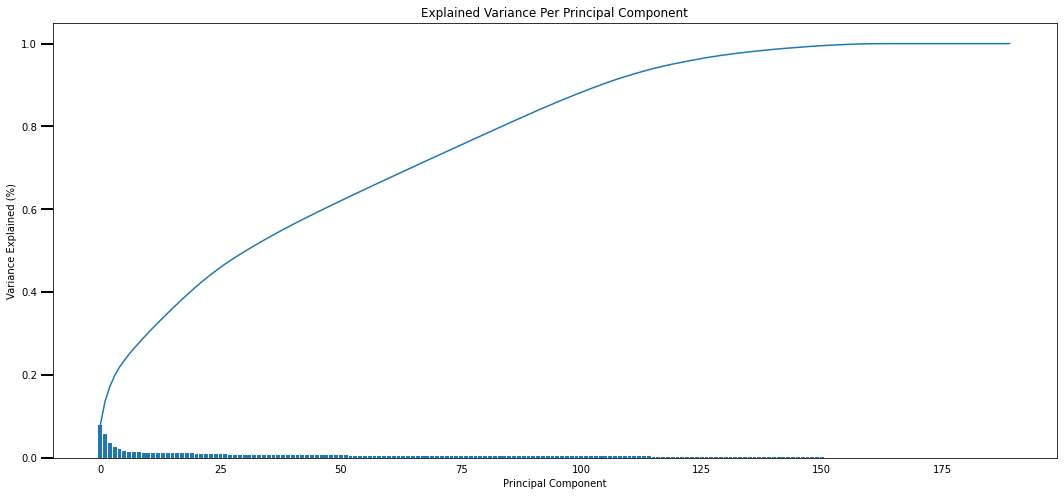

In [98]:
scree_plot(pca)

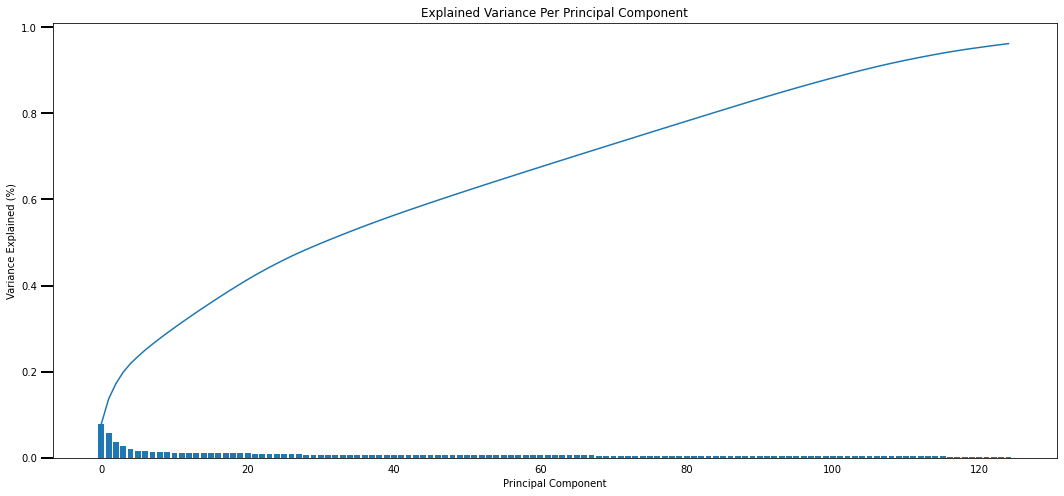

In [99]:
scree_plot(pca, components_no = 125)

In [100]:
pca.explained_variance_ratio_[:10].sum()

0.289948141763364

In [101]:
azdias5.shape

(797961, 190)

First 10 components capture 29% of variance

In [102]:
for i in np.arange(10, 131, 10):
    print('{} components explain {} of variance.'.format(i, pca.explained_variance_ratio_[:i].sum()))

10 components explain 0.289948141763364 of variance.
20 components explain 0.40368865257125197 of variance.
30 components explain 0.4909674780522247 of variance.
40 components explain 0.5572267978112325 of variance.
50 components explain 0.615126724230554 of variance.
60 components explain 0.6699609167745911 of variance.
70 components explain 0.7236061259758326 of variance.
80 components explain 0.7766714220757915 of variance.
90 components explain 0.829031111162018 of variance.
100 components explain 0.8779682016983307 of variance.
110 components explain 0.9200428017295385 of variance.
120 components explain 0.9507005348475357 of variance.
130 components explain 0.9715019613898137 of variance.


100 components can explain more than 87.8% of the variance. This looks good enough

In [103]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=100)
azdias_pca = pca.fit_transform(azdias5)

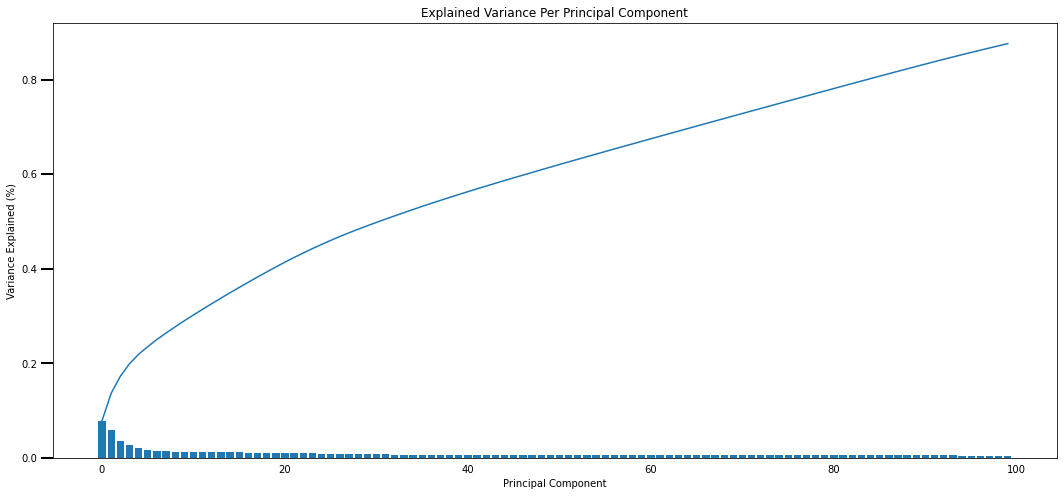

In [104]:
scree_plot(pca, show_labels = False)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Reducing dataset dimension by almost half from 190 to 100 still allow us to capture more than 87% of the variance. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

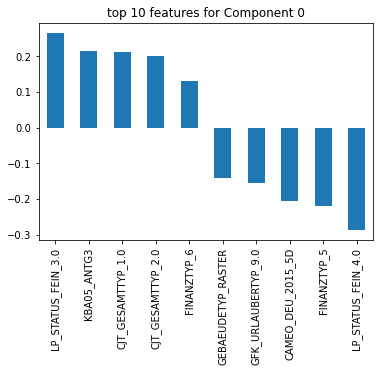

LP_STATUS_FEIN_3.0     0.266138
KBA05_ANTG3            0.213996
CJT_GESAMTTYP_1.0      0.211311
CJT_GESAMTTYP_2.0      0.200898
FINANZTYP_6            0.130533
GEBAEUDETYP_RASTER    -0.140766
GFK_URLAUBERTYP_9.0   -0.154674
CAMEO_DEU_2015_5D     -0.205530
FINANZTYP_5           -0.218896
LP_STATUS_FEIN_4.0    -0.287905
Name: 99, dtype: float64

In [105]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def top_pca_result(df, pca, component_no, features_no):
    pca_comp = pd.DataFrame(pca.components_, columns = df.columns).iloc[component_no-1]
    pca_comp.sort_values(ascending = False, inplace = True)
    
    result = pd.concat([pca_comp.head(features_no), pca_comp.tail(features_no)])
    
    result.plot(kind = 'bar', title = "top {} features for Component {}".format(features_no*2, component_no))
    plt.show()
    
    return result
    
top_pca_result(azdias5, pca, 0, 5)

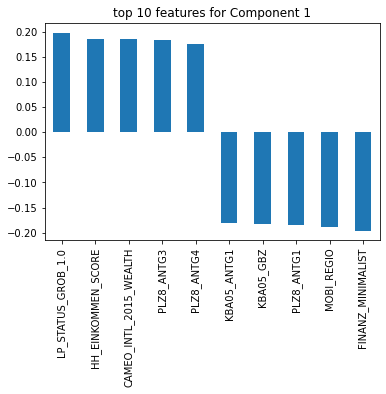

LP_STATUS_GROB_1.0        0.197377
HH_EINKOMMEN_SCORE        0.185326
CAMEO_INTL_2015_WEALTH    0.184685
PLZ8_ANTG3                0.182766
PLZ8_ANTG4                0.176181
KBA05_ANTG1              -0.181189
KBA05_GBZ                -0.181808
PLZ8_ANTG1               -0.183850
MOBI_REGIO               -0.188680
FINANZ_MINIMALIST        -0.195811
Name: 0, dtype: float64

In [106]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

top_pca_result(azdias5, pca, 1, 5)

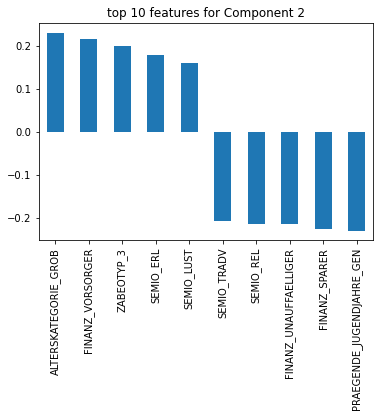

ALTERSKATEGORIE_GROB         0.230961
FINANZ_VORSORGER             0.216942
ZABEOTYP_3                   0.200180
SEMIO_ERL                    0.179415
SEMIO_LUST                   0.161726
SEMIO_TRADV                 -0.206414
SEMIO_REL                   -0.213466
FINANZ_UNAUFFAELLIGER       -0.214699
FINANZ_SPARER               -0.224351
PRAEGENDE_JUGENDJAHRE_GEN   -0.229002
Name: 1, dtype: float64

In [107]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

top_pca_result(azdias5, pca, 2, 5)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)  

**PC 0**    
First Principal Component is positively associated with:

| Attribute | Weight | Definition |
| :------------:   | :--------: | :-------------: | 
|LP_STATUS_FEIN_3.0   |   0.266138 | aspiring low-income earners |
|KBA05_ANTG3          |   0.213996 |Number of 6-10 family houses in the microcell |
|CJT_GESAMTTYP_1.0    |   0.211311 | Customer-Journey-Typology: Advertising- and Consumptionminimalist |
|CJT_GESAMTTYP_2.0    |   0.200898 | Customer-Journey-Typology:  Advertising- and Consumptiontraditionalist |
|FINANZTYP_6          |   0.130533 | Financial Typology: inconspicuous |


First Principal Component is negatively associated with:  

| Attribute | Weight | Definition |
| :------------:        | :--------: | :-------------: | 
GEBAEUDETYP_RASTER         |   -0.140766 | Ratio of residential to commercial activity|
GFK_URLAUBERTYP_9.0 |   -0.154674 | Vacation Habit: Package tour travelers|
CAMEO_DEU_2015_5D          |  -0.205530 | Stock Market Junkies |
FINANZTYP_5         |   -0.218896 | investor |
LP_STATUS_FEIN_4.0     |    -0.287905| Villagers |

**PC 0 is mostly influenced income level and consumption preference. This PC seems to represent lower income group with minimalist and traditional consumption preference, influenced by advertisement.**

**PC 1**  
Second Principal Component is positively associated with:  

| Attribute | Weight | Definition |
| :------------:        | :--------: | :-------------: | 
|LP_STATUS_GROB_1.0       | 0.197377 | Social status: low-income earners |
|HH_EINKOMMEN_SCORE       | 0.185326 | Estimated Household net income |
|CAMEO_INTL_2015_WEALTH   | 0.184685 | Wealth / Life Stage Typology |
|PLZ8_ANTG3               | 0.182766 | Number of 6-10 family houses in the PLZ8 region |
|PLZ8_ANTG4               | 0.176181 | Number of 10+ family houses in the PLZ8 region |

Second Principal Component is negatively associated with:  

| Attribute | Weight | Definition |
| :------------:        | :--------: | :-------------: | 
|KBA05_ANTG1            |  -0.181189 | Number of 1-2 family houses in the microcell |
|KBA05_GBZ              |  -0.181808 | Number of buildings in the microcell |
|PLZ8_ANTG1             |  -0.183850 | Number of 1-2 family houses in the PLZ8 region |
|MOBI_REGIO             |  -0.188680 | Movement Patterns |
|FINANZ_MINIMALIST      |  -0.195811 | Financial Typology: low financial interest |


**PC 1 is most influenced by social status, household income, neighbourhood and movement pattern. Most likely lower income group**  

**PC 2**  
Third Principal Component is positively associated with:  

| Attribute | Weight | Definition |
| :------------:        | :--------: | :-------------: | 
|ALTERSKATEGORIE_GROB     |    0.230961 | Estimated age based on given name analysis |
|FINANZ_VORSORGER         |    0.216942 | Financial Typology: Be prepared |
|ZABEOTYP_3               |    0.200180 | Energy consumption typology: fair supplied |
|SEMIO_ERL                |    0.179415 | Personality typology: event oriented |
|SEMIO_LUST               |    0.161726 | Personality typology: sensual-minded |


Third Principal Component is negatively associated with:  

| Attribute | Weight | Definition |
| :------------:        | :--------: | :-------------: | 
|SEMIO_TRADV               |  -0.206415 | Personality typology: traditional-minded |
|SEMIO_REL                 |  -0.213466 | Personality typology: religious |
|FINANZ_UNAUFFAELLIGER     |  -0.214699 | Financial typology: inconspicuous |
|FINANZ_SPARER             |  -0.224351 | Financial typology: money-saver |
|PRAEGENDE_JUGENDJAHRE_GEN |  -0.229002 | Generation group |

**PC2 is most influenced by financial perspective, personality and religiousness. This PC represents people who are not religious, financially prepared.**

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [108]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

In [109]:
# Over a number of different cluster counts...
cluster_no = np.arange(10,26)
scores = []

# run k-means clustering on the data and...
for cluster in cluster_no:
    start = time.time()
    mbkmeans = MiniBatchKMeans(n_clusters = cluster, random_state = 123)
    model = mbkmeans.fit(azdias_pca)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(azdias_pca))
    scores.append(score)
    end = time.time()
    
    print(f"Score for {cluster} clusters: {score}")
    print(f"Time taken: {end-start:.2f} seconds")
    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Score for 10 clusters: 111970952.77424502
Time taken: 2.44 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Score for 11 clusters: 111718145.61091013
Time taken: 2.11 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Score for 12 clusters: 110359501.24202049
Time taken: 2.08 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Score for 13 clusters: 109405949.73204485
Time taken: 2.11 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Score for 14 clusters: 105735368.87460345
Time taken: 5.56 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Score for 15 clusters: 104986260.44215211
Time taken: 5.81 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Score for 16 clusters: 104429737.65099582
Time taken: 6.26 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Score for 17 clusters: 103870780.5139626
Time taken: 6.83 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Score for 18 clusters: 102960095.70429932
Time taken: 8.15 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Score for 19 clusters: 102531110.2648545
Time taken: 7.49 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Score for 20 clusters: 102220090.66679445
Time taken: 6.58 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Score for 21 clusters: 101054052.54733709
Time taken: 7.43 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Score for 22 clusters: 100051072.57704012
Time taken: 7.39 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Score for 23 clusters: 99337131.10802299
Time taken: 7.61 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Score for 24 clusters: 99309300.75767177
Time taken: 7.48 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Score for 25 clusters: 98654749.08568043
Time taken: 6.63 seconds


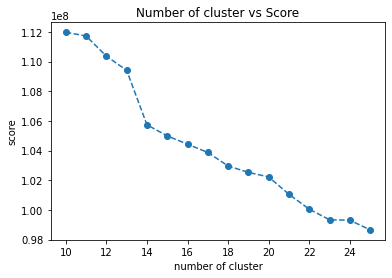

In [110]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(cluster_no, scores, marker = "o", linestyle = "--" )

plt.xlabel("number of cluster")
plt.ylabel("score")
plt.title("Number of cluster vs Score")
plt.show()

A few elbows here, 14 and 23. A mini elbow at 18. We try 18 which is in between 14 and 22.

In [189]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

start = time.time()

kmeans = MiniBatchKMeans(n_clusters = 18)
final_model = kmeans.fit(azdias_pca)

# generate cluster on general population data
population_cluster = final_model.predict(azdias_pca)

end = time.time()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [190]:
print(f"Time taken: {end-start:.2f} seconds")

Time taken: 2.56 seconds


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

We tried fitting 10 to 25 number of clusters and plotted the score. There are multiple elbows and score reduction seems to temporarily diminish at 18 thus 18 clusters were chosen for final model.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [113]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [114]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               191652 non-null  int64  
 1   ALTERSKATEGORIE_GROB   191652 non-null  int64  
 2   ANREDE_KZ              191652 non-null  int64  
 3   CJT_GESAMTTYP          188439 non-null  float64
 4   FINANZ_MINIMALIST      191652 non-null  int64  
 5   FINANZ_SPARER          191652 non-null  int64  
 6   FINANZ_VORSORGER       191652 non-null  int64  
 7   FINANZ_ANLEGER         191652 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  191652 non-null  int64  
 9   FINANZ_HAUSBAUER       191652 non-null  int64  
 10  FINANZTYP              191652 non-null  int64  
 11  GEBURTSJAHR            191652 non-null  int64  
 12  GFK_URLAUBERTYP        188439 non-null  float64
 13  GREEN_AVANTGARDE       191652 non-null  int64  
 14  HEALTH_TYP             191652 non-nu

In [115]:
customers['OST_WEST_KZ'].value_counts()

W    130382
O     11343
Name: OST_WEST_KZ, dtype: int64

**Preprocessing, Feature Transformation and Cleaning**

In [116]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

cleaned_customers = clean_data(customers)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [117]:
cleaned_customers.shape[1] == azdias5.shape[1]

True

In [118]:
azdias5_col = list(azdias5.columns)

In [119]:
cleaned_cust_col = list(cleaned_customers.columns)

In [120]:
# check for difference in col name
new_list = list(set(azdias5_col).difference(cleaned_cust_col))
new_list

[]

No difference in column name after cleaning

cleaned_customers has same column count as azdias5

**Impute NaN**

In [121]:
len(cleaned_customers.columns)

190

In [122]:
len(azdias5.columns)

190

In [123]:
new_list = list(set(azdias4.columns).difference(cleaned_cust_col))
new_list

[]

In [124]:
len(azdias4.columns[~azdias4.columns.isin(num_var)])

184

In [125]:
len(cleaned_customers.columns[azdias4.columns.isin(num_var)])

6

In [ ]:
'''
# does not work on transforming cleaned_customers

cleaned_customers = pd.DataFrame(med_imp.transform(cleaned_customers), 
                                 index = cleaned_customers.index, 
                                 columns = cleaned_customers.columns)


cleaned_customers = pd.DataFrame(ct.transform(cleaned_customers),
                                index = cleaned_customers.index, 
                                 columns = cleaned_customers.columns)
'''

**Impute NaN**

In [126]:
# Impute numerical data with median
cleaned_customers[cleaned_customers.columns[cleaned_customers.columns.isin(num_var)]] = med_imp.transform(cleaned_customers[cleaned_customers.columns[cleaned_customers.columns.isin(num_var)]])

In [127]:
# Impute categorical data with most frequent value
cleaned_customers[cleaned_customers.columns[~cleaned_customers.columns.isin(num_var)]] = most_freq_imp.transform(cleaned_customers[cleaned_customers.columns[~cleaned_customers.columns.isin(num_var)]])

In [128]:
cleaned_customers.isnull().sum().sum()

0

In [129]:
cleaned_customers.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   4.0        1.0                5.0            1.0   
2                   4.0        2.0                5.0            1.0   
3                   4.0        1.0                5.0            1.0   
4                   3.0        1.0                3.0            1.0   
5                   3.0        1.0                5.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0               5.0             1.0                    2.0               2.0   
2               5.0             1.0                    4.0               4.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             4.0                    5.0               2.0   
5               5.0             1.0                    2.0               3.0   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0               1.0         1.0             5.0        6.0        5.0   
2               1.0         2.0             5.0        2.0        2.0   
3               0.0         2.0             3.0        6.0        5.0   
4               0.0         3.0             5.0        4.0        5.0   
5               1.0         3.0             3.0        6.0        4.0   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
0        2.0        6.0         6.0         7.0        3.0         4.0   
2        1.0        3.0         3.0         7.0        7.0         1.0   
3        3.0        4.0         7.0         5.0        3.0         4.0   
4        4.0        6.0         5.0         6.0        4.0         5.0   
5        4.0        1.0         7.0         6.0        4.0         6.0   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
0        1.0         3.0        1.0         1.0            2.0          1.0   
2        2.0         7.0        5.0         6.0            4.0          1.0   
3        3.0         3.0        3.0         3.0            3.0          4.0   
4        5.0         3.0        5.0         2.0            5.0          4.0   
5        2.0         5.0        5.0         3.0            3.0          4.0   

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
0      0.0       1.0           2.0        0.0                 1.0   
2      0.0       2.0           1.0        0.0                 1.0   
3      0.0       1.0           0.0        0.0                 4.0   
4      0.0       2.0           4.0        0.0                 6.0   
5      0.0       2.0           2.0        0.0                 1.0   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0             6.0             9.0                  1.0           0.0   
2             6.0             9.0                  1.0           0.0   
3             6.0             9.0                  4.0           0.0   
4             2.0             9.0                  7.0           0.0   
5             6.0             9.0                  1.0           0.0   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  OST_WEST_KZ  KBA05_ANTG1  KBA05_ANTG2  \
0          5.0            1992.0          1.0          2.0          2.0   
2          1.0            1992.0          1.0          2.0          2.0   
3          2.0            1992.0          1.0          3.0          0.0   
4          1.0            1992.0          1.0          0.0          3.0   
5          2.0            1992.0          1.0          2.0          2.0   

   KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  \
0          0.0          0.0        4.0       3.0       2.0         4.0   
2          0.0          0.0        3.0       7.0       4.0         1.0   
3          0.0          0.0        4.0       7.0       1.0         7.0   
4          2.0          0.0        3.0       3.0       4.0         4.0   
5          1.0          0.0        3.0       7.0       5.0   

**Feature Scaling**

In [130]:
# scaling
cleaned_customers = pd.DataFrame(scaler.transform(cleaned_customers), 
                                 index = cleaned_customers.index, 
                                 columns = cleaned_customers.columns)

In [131]:
cleaned_customers.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0              1.184102  -1.043914           1.409077      -1.155482   
2              1.184102   0.957933           1.409077      -1.155482   
3              1.184102  -1.043914           1.409077      -1.155482   
4              0.200529  -1.043914          -0.042764      -1.155482   
5              0.200529  -1.043914           1.409077      -1.155482   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0          1.138133       -1.249960              -0.470299         -0.791347   
2          1.138133       -1.249960               0.958818          0.629041   
3          1.138133       -0.570958              -1.184858         -0.791347   
4          0.411859        0.787046               1.673376         -0.791347   
5          1.138133       -1.249960              -0.470299         -0.081153   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0          1.885219   -1.633781        1.063718   0.958341   0.463245   
2          1.885219   -0.311795        1.063718  -1.102521  -1.104409   
3         -0.530442   -0.311795       -0.310826   0.958341   0.463245   
4         -0.530442    1.010191        1.063718  -0.072090   0.463245   
5          1.885219    1.010191       -0.310826   0.958341  -0.059306   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
0  -1.043961   1.104184    0.885447    1.267957  -0.888005   -0.067417   
2  -1.567397  -0.463834   -0.656581    1.267957   1.301646   -1.599754   
3  -0.520526   0.058838    1.399457    0.316813  -0.888005   -0.067417   
4   0.002910   1.104184    0.371438    0.792385  -0.340592    0.443362   
5   0.002910  -1.509180    1.399457    0.792385  -0.340592    0.954141   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
0  -1.750649   -0.880231  -1.946324   -1.763850      -1.178258    -1.543029   
2  -1.145683    1.392131   0.244065    0.913295      -0.099501    -1.543029   
3  -0.540717   -0.880231  -0.851129   -0.692992      -0.638880     0.156158   
4   0.669215   -0.880231   0.244065   -1.228421       0.439877     0.156158   
5  -1.145683    0.255950   0.244065   -0.692992      -0.638880     0.156158   

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
0 -0.09213 -1.083500      0.234378  -0.060412           -2.209229   
2 -0.09213  0.922935     -0.630291  -0.060412           -2.209229   
3 -0.09213 -1.083500     -1.494960  -0.060412           -0.267724   
4 -0.09213  0.922935      1.963716  -0.060412            1.026614   
5 -0.09213  0.922935      0.234378  -0.060412           -2.209229   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0        0.957080         0.56721            -0.468769     -0.125139   
2        0.957080         0.56721            -0.468769     -0.125139   
3        0.957080         0.56721            -0.276656     -0.125139   
4       -1.292563         0.56721            -0.084544     -0.125139   
5        0.957080         0.56721            -0.468769     -0.125139   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  OST_WEST_KZ  KBA05_ANTG1  KBA05_ANTG2  \
0     1.274897         -0.383241     0.517442     0.412864     0.641143   
2    -1.304504         -0.383241     0.517442     0.412864     0.641143   
3    -0.659653         -0.383241     0.517442     1.123781    -0.965814   
4    -1.304504         -0.383241     0.517442    -1.008971     1.444621   
5    -0.659653         -0.383241     0.517442     0.412864     0.641143   

   KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  \
0    -0.594928    -0.464121    0.65529 -0.528677 -1.128849   -0.271044   
2    -0.594928    -0.464121   -0.11620  1.303251  0.034445   -1.750188   
3    -0.594928    -0.464121    0.65529  1.303251 -1.710496    1.208100   
4     1.411001    -0.464121   -0.11620 -0.528677  0.034445   -0.271044   
5     0.408037    -0.464121   -0.11620  1.303251  0.616092   

In [132]:
cleaned_customers.shape

(141720, 190)

**PCA**

In [158]:
# Apply previously set PCA parameters to Customers Data
customers_pca = pca.transform(cleaned_customers)

**Clustering**

In [191]:
# Clustering - using previously trained clustering
customers_cluster = final_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [192]:
df_pop_pred = pd.DataFrame(population_cluster, columns = ['pop_pred'])
df_cust_pred = pd.DataFrame(customers_cluster, columns = ['cust_pred'])

In [193]:
pop_cluster = df_pop_pred.value_counts().sort_index()

In [194]:
pop_cluster

pop_pred
0            13191
1            18545
2            38459
3           109601
4            14324
5            73222
6            67100
7            41621
8            96541
9            12196
10            7152
11           10841
12           49402
13            4633
14           73732
15           17671
16           86834
17           62896
dtype: int64

In [195]:
cust_cluster = df_cust_pred.value_counts().sort_index()

In [196]:
cust_cluster

cust_pred
0             3317
1            10026
2              461
3            30225
4              795
5            22568
6             6457
7            23391
8              774
9             1454
10            6098
11            1044
12            5087
13            4248
14            1245
15            6052
16           17816
17             662
dtype: int64

In [197]:
combined_cluster = pd.concat([pop_cluster, cust_cluster], axis = 1).reset_index()
combined_cluster.columns = ['cluster', 'population', 'customer']
combined_cluster

cluster  population  customer
0         0       13191      3317
1         1       18545     10026
2         2       38459       461
3         3      109601     30225
4         4       14324       795
5         5       73222     22568
6         6       67100      6457
7         7       41621     23391
8         8       96541       774
9         9       12196      1454
10       10        7152      6098
11       11       10841      1044
12       12       49402      5087
13       13        4633      4248
14       14       73732      1245
15       15       17671      6052
16       16       86834     17816
17       17       62896       662

In [198]:
# calculate proportion of each
combined_cluster['pop_proportion'] = combined_cluster['population']/(combined_cluster['population'].sum())
combined_cluster['cust_proportion'] = combined_cluster['customer']/(combined_cluster['customer'].sum())
combined_cluster

cluster  population  customer  pop_proportion  cust_proportion
0         0       13191      3317        0.016531         0.023405
1         1       18545     10026        0.023240         0.070745
2         2       38459       461        0.048197         0.003253
3         3      109601     30225        0.137351         0.213273
4         4       14324       795        0.017951         0.005610
5         5       73222     22568        0.091761         0.159244
6         6       67100      6457        0.084089         0.045562
7         7       41621     23391        0.052159         0.165051
8         8       96541       774        0.120985         0.005461
9         9       12196      1454        0.015284         0.010260
10       10        7152      6098        0.008963         0.043029
11       11       10841      1044        0.013586         0.007367
12       12       49402      5087        0.061910         0.035895
13       13        4633      4248        0.005806         0.029975
14       14       73732      1245        0.092401         0.008785
15       15       17671      6052        0.022145         0.042704
16       16       86834     17816        0.108820         0.125713
17       17       62896       662        0.078821         0.004671

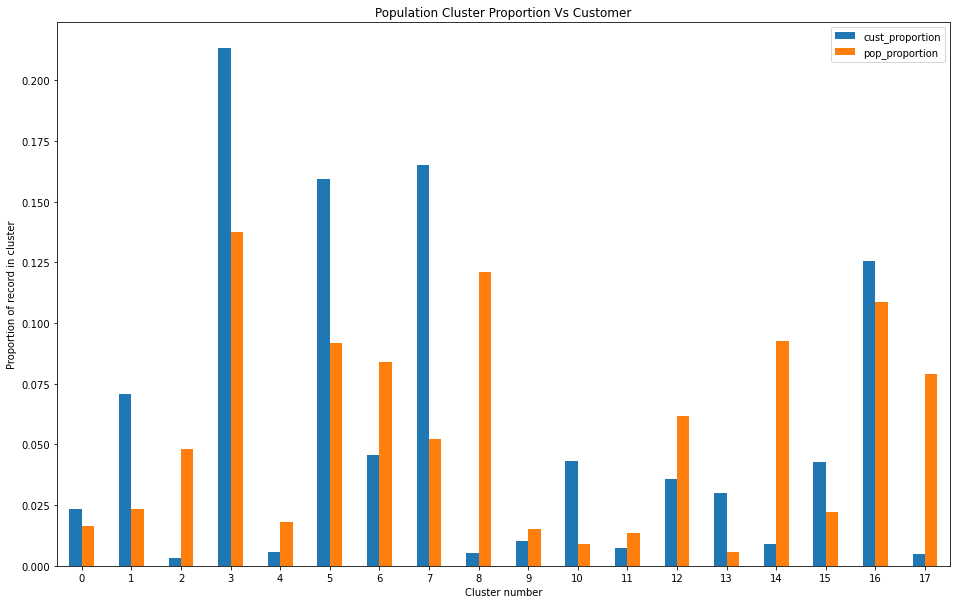

In [199]:
combined_cluster.plot(x="cluster", y = ['cust_proportion', 'pop_proportion'], kind = 'bar', figsize = (16, 10))
plt.title('Population Cluster Proportion Vs Customer')
plt.xlabel('Cluster number')
plt.ylabel('Proportion of record in cluster')
plt.xticks(rotation = 360)
plt.show()

In [200]:
# alternative plot using seaborn
combined_cluster1 = pd.melt(combined_cluster[['cluster','cust_proportion', 'pop_proportion']], id_vars = 'cluster')

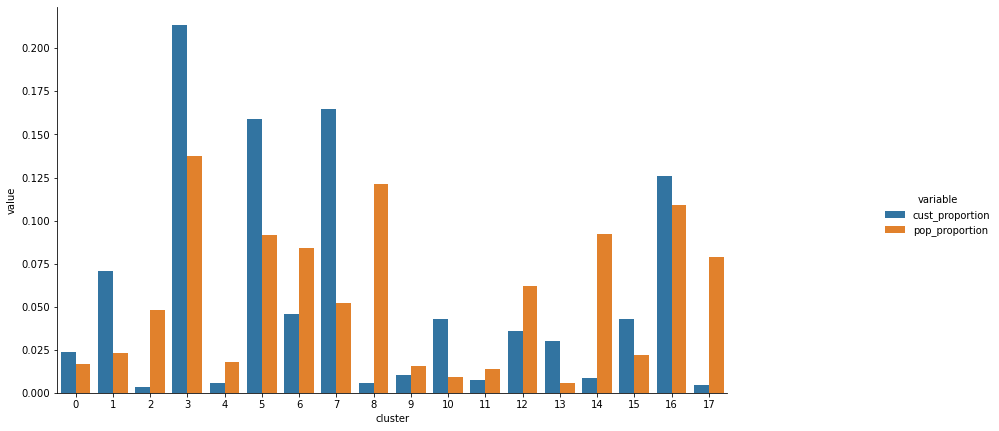

In [201]:
graph = sns.catplot(x = 'cluster', y = 'value', hue = 'variable', kind = 'bar', data = combined_cluster1)
graph.fig.set_figwidth(15)
graph.fig.set_figheight(6)


Most significant differences between the 2 populations:  
General Population:  
* Cluster 8  : 12 times Customer  
* Cluster 14  : 9 times Customer  
* Cluster 17  : 8 times Customer  
* Cluster 2 : 5 times Customer  

Customer:  
* Cluster 7: 3 times General Population
* Cluster 3: 1.5 times General Population
* Cluster 5: 1.8 times General Population
* Cluster 10: 4 times General Population

**Cluster 7 - Over-represented in customer data**

In [203]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster 7 - Customer Over Represented

# extract cluster 7 top 5 principal components

top_pc_7 = pd.Series(final_model.cluster_centers_[7])


In [204]:
# Cluster 7 top 5 principal components
top_pc_7.sort_values(ascending = False, inplace = True)
top_pc_7.head(5)

2     2.864157
1     2.806416
7     0.977639
28    0.766101
21    0.691309
dtype: float64

In [205]:
# Inverse transform centroid back to original data space
top_pc_7_inv = pd.Series(scaler.inverse_transform(pca.inverse_transform(top_pc_7))).round()
top_pc_7_inv.index = cleaned_customers.columns
top_pc_7_inv

ALTERSKATEGORIE_GROB            3.0
ANREDE_KZ                       1.0
FINANZ_MINIMALIST               3.0
FINANZ_SPARER                   2.0
FINANZ_VORSORGER                4.0
FINANZ_ANLEGER                  2.0
FINANZ_UNAUFFAELLIGER           2.0
FINANZ_HAUSBAUER                4.0
GREEN_AVANTGARDE                0.0
HEALTH_TYP                      2.0
RETOURTYP_BK_S                  4.0
SEMIO_SOZ                       4.0
SEMIO_FAM                       4.0
SEMIO_REL                       3.0
SEMIO_MAT                       4.0
SEMIO_VERT                      5.0
SEMIO_LUST                      5.0
SEMIO_ERL                       5.0
SEMIO_KULT                      4.0
SEMIO_RAT                       3.0
SEMIO_KRIT                      5.0
SEMIO_DOM                       4.0
SEMIO_KAEM                      4.0
SEMIO_PFLICHT                   3.0
SEMIO_TRADV                     3.0
SOHO_KZ                         0.0
VERS_TYP                        2.0
ANZ_PERSONEN                

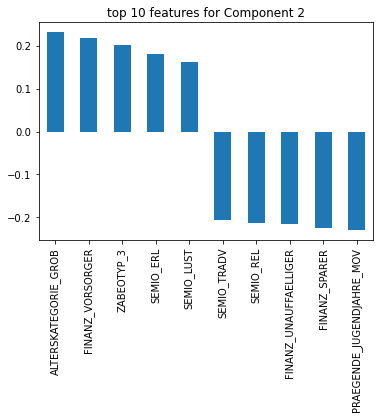

ALTERSKATEGORIE_GROB         0.230961
FINANZ_VORSORGER             0.216942
ZABEOTYP_3                   0.200180
SEMIO_ERL                    0.179415
SEMIO_LUST                   0.161726
SEMIO_TRADV                 -0.206414
SEMIO_REL                   -0.213466
FINANZ_UNAUFFAELLIGER       -0.214699
FINANZ_SPARER               -0.224351
PRAEGENDE_JUGENDJAHRE_MOV   -0.229002
Name: 1, dtype: float64

In [207]:
# Analyze 2 top principal components of cluster 7
# PC 2
top_pca_result(cleaned_customers, pca, 2, 5)

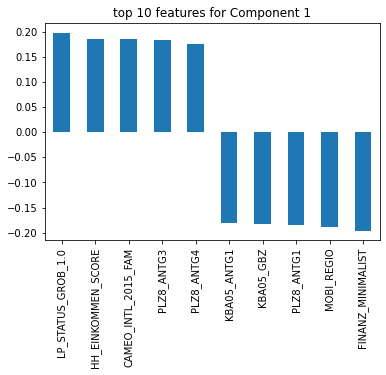

LP_STATUS_GROB_1.0     0.197377
HH_EINKOMMEN_SCORE     0.185326
CAMEO_INTL_2015_FAM    0.184685
PLZ8_ANTG3             0.182766
PLZ8_ANTG4             0.176181
KBA05_ANTG1           -0.181189
KBA05_GBZ             -0.181808
PLZ8_ANTG1            -0.183850
MOBI_REGIO            -0.188680
FINANZ_MINIMALIST     -0.195811
Name: 0, dtype: float64

In [214]:
# PC 1
top_pca_result(cleaned_customers, pca, 1, 5)

**Analysis**  
This cluster is positively influenced by:  

| Attribute | Weight | Definition |
|:------------:| :------------: | :------------:| 
|ALTERSKATEGORIE_GROB |  0.230961 | Estimated age based on given name analysis |
|FINANZ_VORSORGER     |  0.216942 | Financial Typology: be prepared |
|ZABEOTYP_3           |  0.200180 | Energy Consumption: fair supplied |
|SEMIO_ERL            |  0.179415 | Event - oriented|
|SEMIO_LUST           |  0.161726 | sensual-minded|
|LP_STATUS_GROB_1.0   |  0.197377 | low-income earners |
|HH_EINKOMMEN_SCORE   |  0.185326 | Estimated household net income |
|CAMEO_INTL_2015_FAM  |  0.184685 | Wealth / Life Stage Typology |
|PLZ8_ANTG3           |  0.182766 | Number of 6-10 family houses in the PLZ8 region |
|PLZ8_ANTG4           |  0.176181 | Number of 10+ family houses in the PLZ8 region |


Cluster 7 is one the clusters overrepresented in customer data compared to general population.  
Upon review of the 2 most influencing principal components within the cluster and their weights, this cluster represents middle aged low income earner.

**Cluster 8 - Under-represented in customer data**

In [209]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Cluster 8

In [210]:
# top principal components in Cluster 8
top_pc_8 = pd.Series(final_model.cluster_centers_[8])

In [211]:
top_pc_8.sort_values(ascending = False, inplace = True)
top_pc_8.head(5)

0     4.389255
3     0.473229
12    0.281063
60    0.250187
59    0.222076
dtype: float64

In [186]:
# Inverse transform centroid back to original data space
top_pc_8_inv = pd.Series(scaler.inverse_transform(pca.inverse_transform(top_pc_8))).round()
top_pc_8_inv.index = cleaned_customers.columns
top_pc_8_inv

ALTERSKATEGORIE_GROB            3.0
ANREDE_KZ                       1.0
FINANZ_MINIMALIST               3.0
FINANZ_SPARER                   2.0
FINANZ_VORSORGER                4.0
FINANZ_ANLEGER                  3.0
FINANZ_UNAUFFAELLIGER           2.0
FINANZ_HAUSBAUER                3.0
GREEN_AVANTGARDE                0.0
HEALTH_TYP                      2.0
RETOURTYP_BK_S                  4.0
SEMIO_SOZ                       4.0
SEMIO_FAM                       4.0
SEMIO_REL                       4.0
SEMIO_MAT                       4.0
SEMIO_VERT                      4.0
SEMIO_LUST                      5.0
SEMIO_ERL                       5.0
SEMIO_KULT                      4.0
SEMIO_RAT                       4.0
SEMIO_KRIT                      5.0
SEMIO_DOM                       4.0
SEMIO_KAEM                      4.0
SEMIO_PFLICHT                   4.0
SEMIO_TRADV                     3.0
SOHO_KZ                        -0.0
VERS_TYP                        2.0
ANZ_PERSONEN                

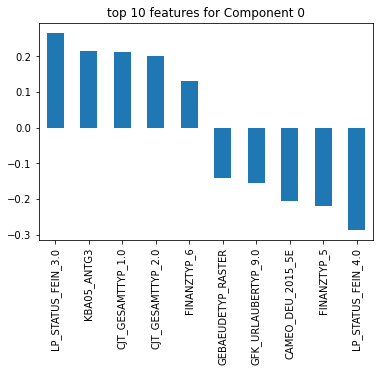

LP_STATUS_FEIN_3.0     0.266138
KBA05_ANTG3            0.213996
CJT_GESAMTTYP_1.0      0.211311
CJT_GESAMTTYP_2.0      0.200898
FINANZTYP_6            0.130533
GEBAEUDETYP_RASTER    -0.140766
GFK_URLAUBERTYP_9.0   -0.154674
CAMEO_DEU_2015_5E     -0.205530
FINANZTYP_5           -0.218896
LP_STATUS_FEIN_4.0    -0.287905
Name: 99, dtype: float64

In [212]:
# Analyze 2 top principal components of cluster 8
# PC 0
top_pca_result(cleaned_customers, pca, 0, 5)

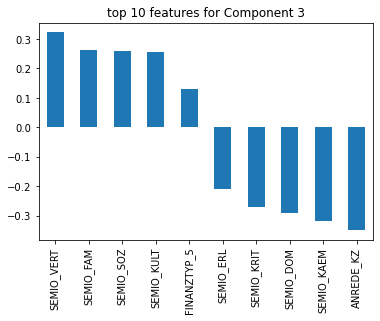

SEMIO_VERT     0.321935
SEMIO_FAM      0.262632
SEMIO_SOZ      0.258155
SEMIO_KULT     0.254774
FINANZTYP_5    0.131668
SEMIO_ERL     -0.208230
SEMIO_KRIT    -0.269230
SEMIO_DOM     -0.289432
SEMIO_KAEM    -0.319068
ANREDE_KZ     -0.348610
Name: 2, dtype: float64

In [213]:
# PC 3
top_pca_result(cleaned_customers, pca, 3, 5)

**Analysis**  
Cluster 8 is positively influenced by:  

| Attribute | Weight | Definition |
|:------------:| :------------: | :------------:| 
|LP_STATUS_FEIN_3.0   |  0.266138 | aspiring low-income earners |
|KBA05_ANTG3          |  0.213996 | Number of 6-10 family houses in the microcell |
|CJT_GESAMTTYP_1.0    |  0.211311 | Advertising- and Consumptionminimalist |
|CJT_GESAMTTYP_2.0    |  0.200898 | Advertising- and Consumptiontraditionalist |
|FINANZTYP_6          |  0.130533 | inconspicuous (UNAUFFAELLIGER) |
|SEMIO_VERT    | 0.321935 | dreamful |
|SEMIO_FAM     | 0.262632 | family-minded |
|SEMIO_SOZ     | 0.258155 | socially-minded |
|SEMIO_KULT    | 0.254774 | cultural-minded |
|FINANZTYP_5   | 0.131668 | investor |


Cluster 8 is one of the clusters underrepresented in customer data compared to general population.  
Based on the 2 most influencing principal components, this cluster consists of aspiring low income earners with a more conservative views who prefer traditional means of shopping and rely on advertising for product information. They are generally family minded, socially minded and care about culture.

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

The mail-order company seems to be popular among middle aged low income earner. Mail-order seems to be the preferred way of shopping for this group of people. 

The mail-order company is not doing well in targetting aspiring low income earners who prefer traditional means of shopping. Given their status as apiring low income earners, there is potential that their income level will grow with time. This is untapped segment that mail-order company can cultivate to diversify its customer base. Customized marketing strategy may be necessary to realize the potential of this segment.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.